# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [1]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [5]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled = bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concatenated = layers.concatenate([upsampled, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(concatenated, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [6]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    encoder_layer1 = encoder_block(inputs, 32, 2)
    encoder_layer2 = encoder_block(encoder_layer1, 64, 2)
    encoder_layer3 = encoder_block(encoder_layer2, 128, 2)
    #encoder_layer4 = encoder_block(encoder_layer3, 256, 2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    conv_layer = conv2d_batchnorm(encoder_layer3, 512, 1, 1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    #decoder_layer4 = decoder_block(conv_layer, encoder_layer3, 256)
    decoder_layer3 = decoder_block(conv_layer, encoder_layer2, 128)
    decoder_layer2 = decoder_block(decoder_layer3, encoder_layer1, 64)
    decoder_layer1 = decoder_block(decoder_layer2, inputs, 32)
    
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(decoder_layer1)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [8]:
learning_rate = 0.00001
batch_size = 100
num_epochs = 300
steps_per_epoch = 42
validation_steps = 14
workers = 2

Epoch 1/300
41/42 [============================>.] - ETA: 1s - loss: 1.4168

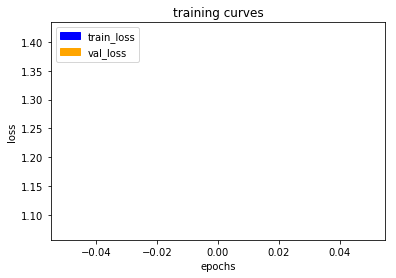

42/42 [==============================] - 66s - loss: 1.4153 - val_loss: 1.0740
Epoch 2/300
41/42 [============================>.] - ETA: 1s - loss: 1.3091

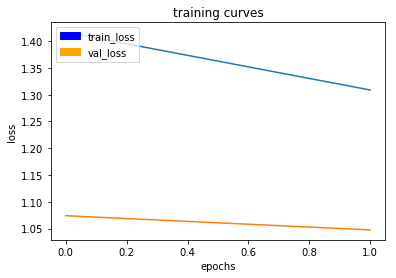

42/42 [==============================] - 62s - loss: 1.3083 - val_loss: 1.0474
Epoch 3/300
41/42 [============================>.] - ETA: 1s - loss: 1.2438

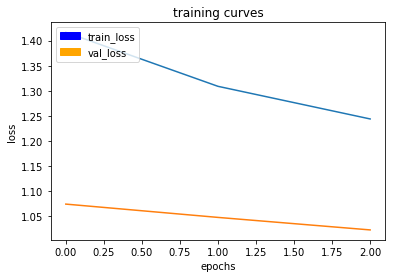

42/42 [==============================] - 62s - loss: 1.2436 - val_loss: 1.0225
Epoch 4/300
41/42 [============================>.] - ETA: 1s - loss: 1.2030

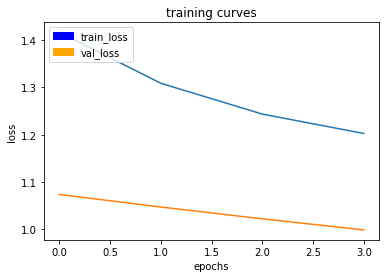

42/42 [==============================] - 62s - loss: 1.2024 - val_loss: 0.9991
Epoch 5/300
41/42 [============================>.] - ETA: 1s - loss: 1.1751

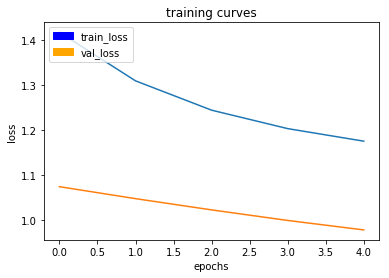

42/42 [==============================] - 61s - loss: 1.1746 - val_loss: 0.9780
Epoch 6/300
41/42 [============================>.] - ETA: 1s - loss: 1.1548

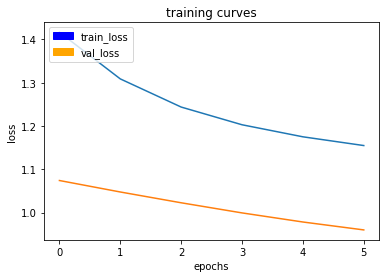

42/42 [==============================] - 62s - loss: 1.1547 - val_loss: 0.9598
Epoch 7/300
41/42 [============================>.] - ETA: 1s - loss: 1.1395

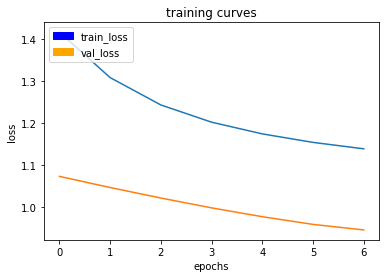

42/42 [==============================] - 61s - loss: 1.1394 - val_loss: 0.9467
Epoch 8/300
41/42 [============================>.] - ETA: 1s - loss: 1.1272

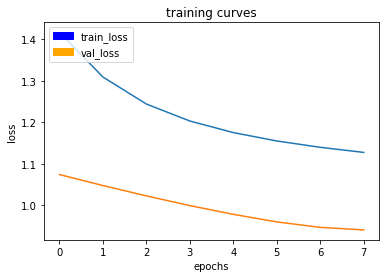

42/42 [==============================] - 61s - loss: 1.1271 - val_loss: 0.9405
Epoch 9/300
41/42 [============================>.] - ETA: 1s - loss: 1.1174

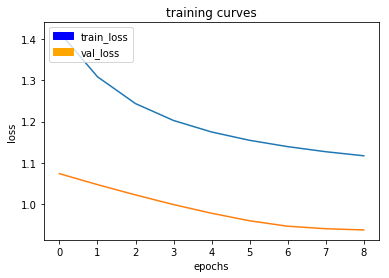

42/42 [==============================] - 62s - loss: 1.1172 - val_loss: 0.9377
Epoch 10/300
41/42 [============================>.] - ETA: 1s - loss: 1.1090

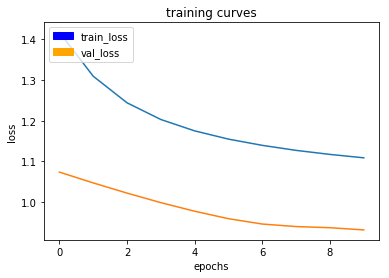

42/42 [==============================] - 61s - loss: 1.1089 - val_loss: 0.9323
Epoch 11/300
41/42 [============================>.] - ETA: 1s - loss: 1.1017

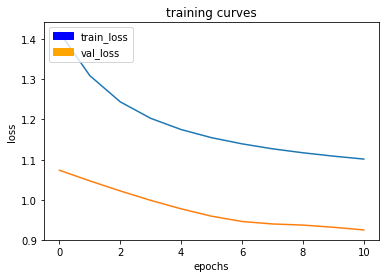

42/42 [==============================] - 61s - loss: 1.1016 - val_loss: 0.9257
Epoch 12/300
41/42 [============================>.] - ETA: 1s - loss: 1.0951

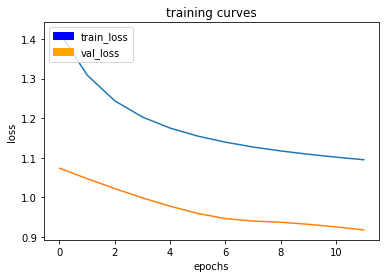

42/42 [==============================] - 62s - loss: 1.0951 - val_loss: 0.9182
Epoch 13/300
41/42 [============================>.] - ETA: 1s - loss: 1.0890

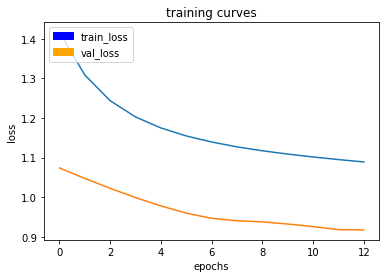

42/42 [==============================] - 62s - loss: 1.0890 - val_loss: 0.9174
Epoch 14/300
41/42 [============================>.] - ETA: 1s - loss: 1.0834

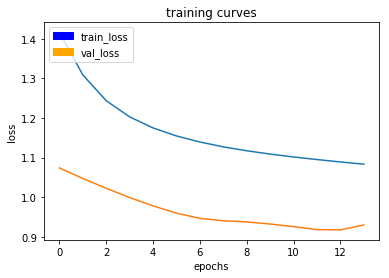

42/42 [==============================] - 62s - loss: 1.0833 - val_loss: 0.9298
Epoch 15/300
41/42 [============================>.] - ETA: 1s - loss: 1.0784

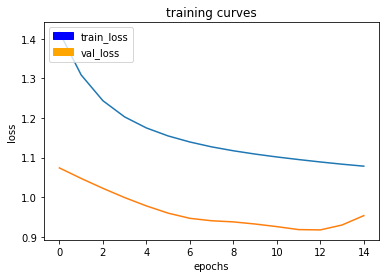

42/42 [==============================] - 62s - loss: 1.0784 - val_loss: 0.9535
Epoch 16/300
41/42 [============================>.] - ETA: 1s - loss: 1.0736

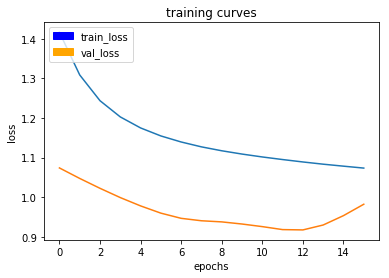

42/42 [==============================] - 62s - loss: 1.0735 - val_loss: 0.9823
Epoch 17/300
41/42 [============================>.] - ETA: 1s - loss: 1.0689

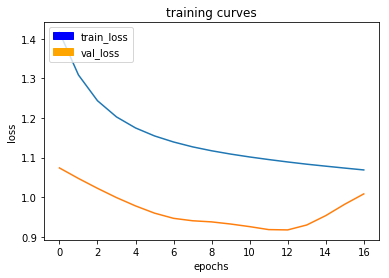

42/42 [==============================] - 61s - loss: 1.0688 - val_loss: 1.0083
Epoch 18/300
41/42 [============================>.] - ETA: 1s - loss: 1.0645

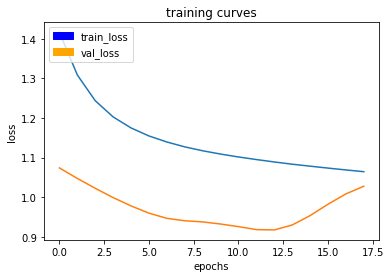

42/42 [==============================] - 61s - loss: 1.0645 - val_loss: 1.0277
Epoch 19/300
41/42 [============================>.] - ETA: 1s - loss: 1.0601

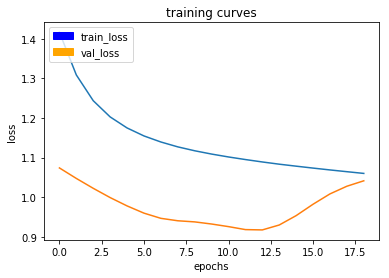

42/42 [==============================] - 62s - loss: 1.0602 - val_loss: 1.0414
Epoch 20/300
41/42 [============================>.] - ETA: 1s - loss: 1.0559

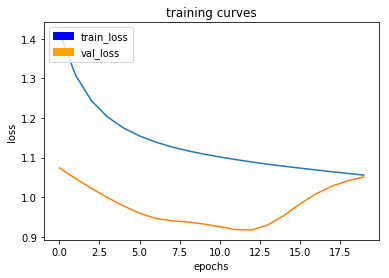

42/42 [==============================] - 62s - loss: 1.0559 - val_loss: 1.0512
Epoch 21/300
41/42 [============================>.] - ETA: 1s - loss: 1.0519

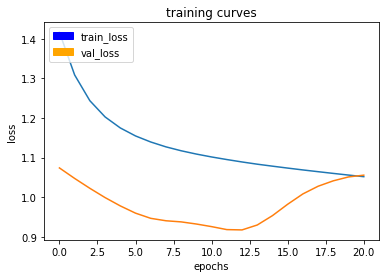

42/42 [==============================] - 61s - loss: 1.0518 - val_loss: 1.0557
Epoch 22/300
41/42 [============================>.] - ETA: 1s - loss: 1.0479

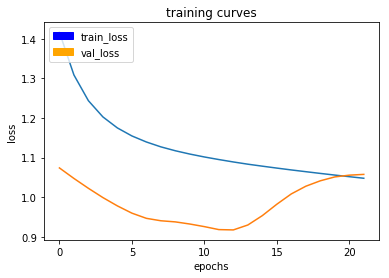

42/42 [==============================] - 62s - loss: 1.0479 - val_loss: 1.0576
Epoch 23/300
41/42 [============================>.] - ETA: 1s - loss: 1.0439

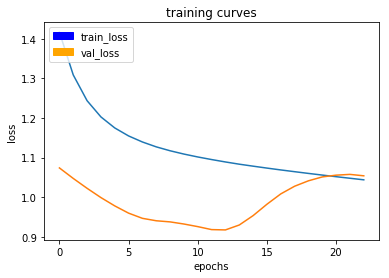

42/42 [==============================] - 62s - loss: 1.0440 - val_loss: 1.0540
Epoch 24/300
41/42 [============================>.] - ETA: 1s - loss: 1.0400

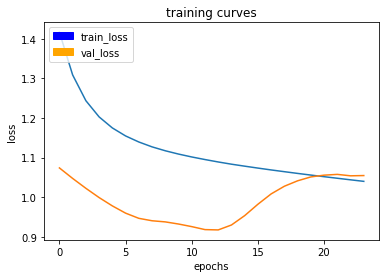

42/42 [==============================] - 62s - loss: 1.0401 - val_loss: 1.0547
Epoch 25/300
41/42 [============================>.] - ETA: 1s - loss: 1.0362

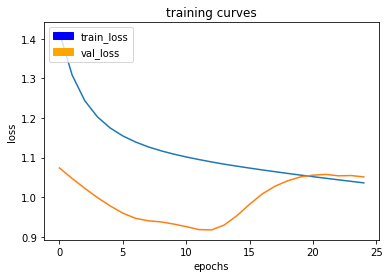

42/42 [==============================] - 62s - loss: 1.0362 - val_loss: 1.0513
Epoch 26/300
41/42 [============================>.] - ETA: 1s - loss: 1.0324

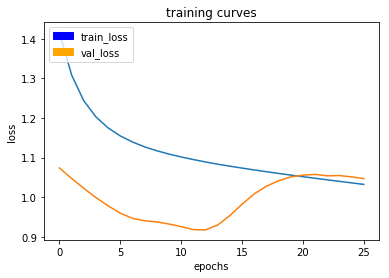

42/42 [==============================] - 61s - loss: 1.0323 - val_loss: 1.0470
Epoch 27/300
41/42 [============================>.] - ETA: 1s - loss: 1.0286

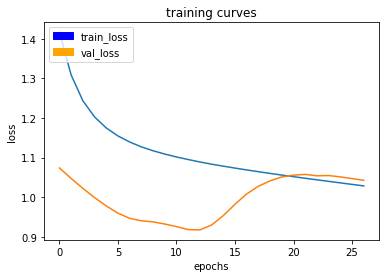

42/42 [==============================] - 62s - loss: 1.0285 - val_loss: 1.0427
Epoch 28/300
41/42 [============================>.] - ETA: 1s - loss: 1.0249

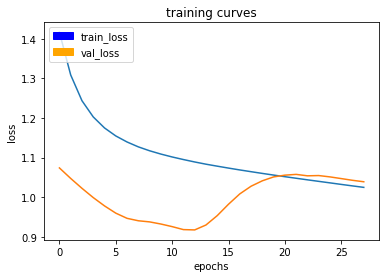

42/42 [==============================] - 62s - loss: 1.0247 - val_loss: 1.0390
Epoch 29/300
41/42 [============================>.] - ETA: 1s - loss: 1.0212

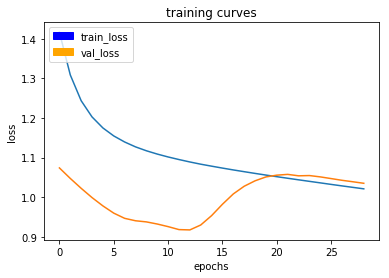

42/42 [==============================] - 61s - loss: 1.0211 - val_loss: 1.0352
Epoch 30/300
41/42 [============================>.] - ETA: 1s - loss: 1.0174

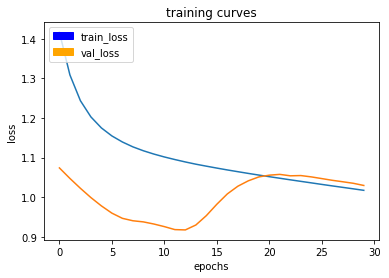

42/42 [==============================] - 62s - loss: 1.0173 - val_loss: 1.0297
Epoch 31/300
41/42 [============================>.] - ETA: 1s - loss: 1.0138

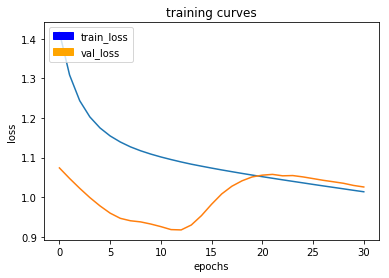

42/42 [==============================] - 62s - loss: 1.0136 - val_loss: 1.0258
Epoch 32/300
41/42 [============================>.] - ETA: 1s - loss: 1.0100

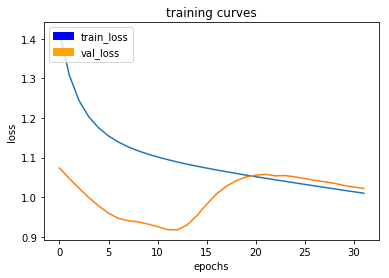

42/42 [==============================] - 62s - loss: 1.0099 - val_loss: 1.0219
Epoch 33/300
41/42 [============================>.] - ETA: 1s - loss: 1.0061

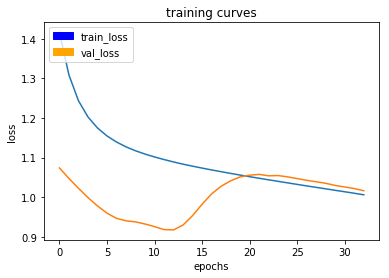

42/42 [==============================] - 61s - loss: 1.0061 - val_loss: 1.0163
Epoch 34/300
41/42 [============================>.] - ETA: 1s - loss: 1.0024

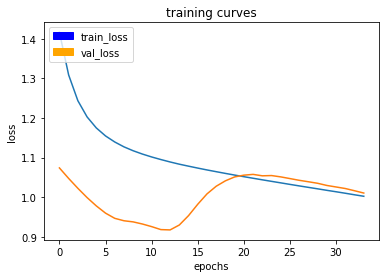

42/42 [==============================] - 62s - loss: 1.0024 - val_loss: 1.0105
Epoch 35/300
41/42 [============================>.] - ETA: 1s - loss: 0.9987

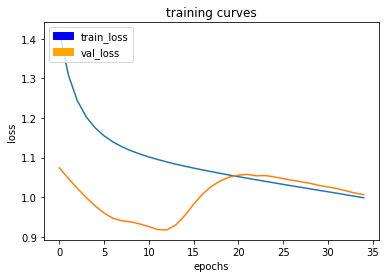

42/42 [==============================] - 62s - loss: 0.9984 - val_loss: 1.0065
Epoch 36/300
41/42 [============================>.] - ETA: 1s - loss: 0.9950

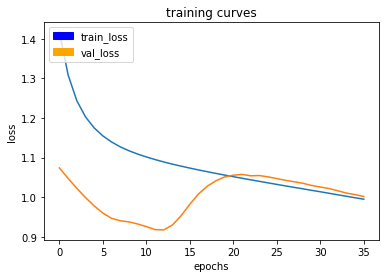

42/42 [==============================] - 62s - loss: 0.9950 - val_loss: 1.0018
Epoch 37/300
41/42 [============================>.] - ETA: 1s - loss: 0.9910

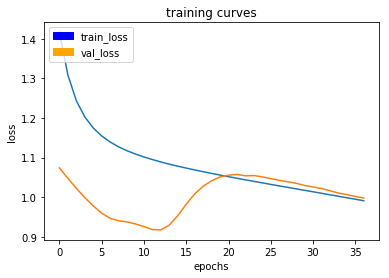

42/42 [==============================] - 62s - loss: 0.9910 - val_loss: 0.9980
Epoch 38/300
41/42 [============================>.] - ETA: 1s - loss: 0.9872

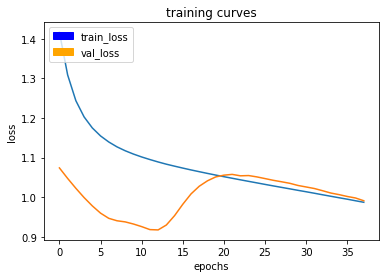

42/42 [==============================] - 62s - loss: 0.9873 - val_loss: 0.9910
Epoch 39/300
41/42 [============================>.] - ETA: 1s - loss: 0.9834

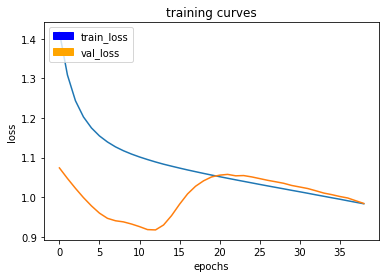

42/42 [==============================] - 62s - loss: 0.9836 - val_loss: 0.9843
Epoch 40/300
41/42 [============================>.] - ETA: 1s - loss: 0.9794

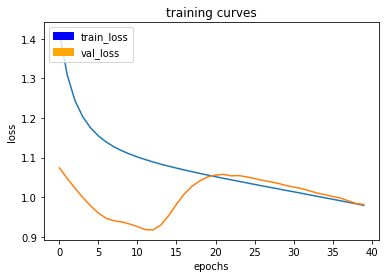

42/42 [==============================] - 61s - loss: 0.9794 - val_loss: 0.9817
Epoch 41/300
41/42 [============================>.] - ETA: 1s - loss: 0.9756

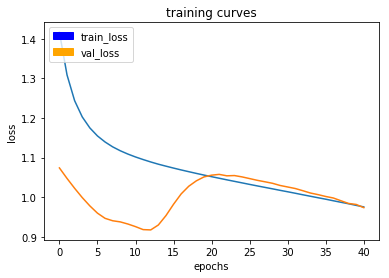

42/42 [==============================] - 61s - loss: 0.9752 - val_loss: 0.9736
Epoch 42/300
41/42 [============================>.] - ETA: 1s - loss: 0.9715

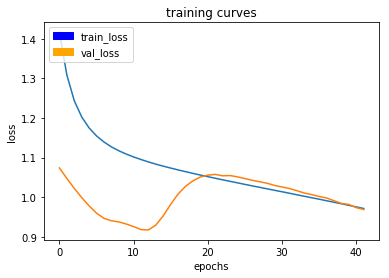

42/42 [==============================] - 62s - loss: 0.9714 - val_loss: 0.9688
Epoch 43/300
41/42 [============================>.] - ETA: 1s - loss: 0.9674

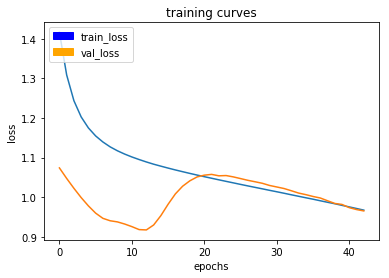

42/42 [==============================] - 62s - loss: 0.9672 - val_loss: 0.9653
Epoch 44/300
41/42 [============================>.] - ETA: 1s - loss: 0.9633

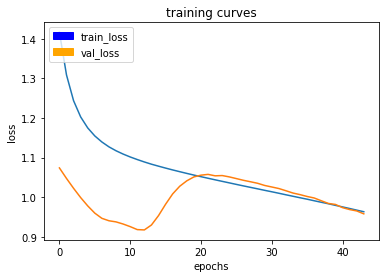

42/42 [==============================] - 62s - loss: 0.9633 - val_loss: 0.9580
Epoch 45/300
41/42 [============================>.] - ETA: 1s - loss: 0.9591

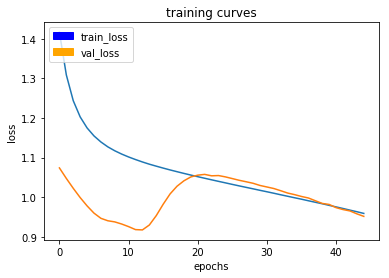

42/42 [==============================] - 62s - loss: 0.9589 - val_loss: 0.9516
Epoch 46/300
41/42 [============================>.] - ETA: 1s - loss: 0.9549

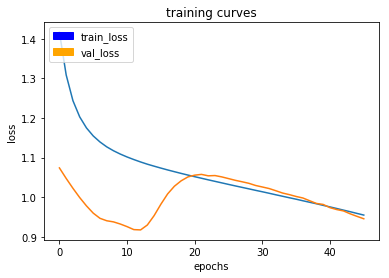

42/42 [==============================] - 61s - loss: 0.9548 - val_loss: 0.9456
Epoch 47/300
41/42 [============================>.] - ETA: 1s - loss: 0.9507

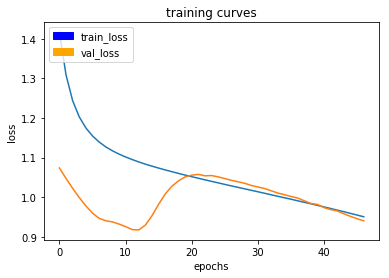

42/42 [==============================] - 62s - loss: 0.9503 - val_loss: 0.9404
Epoch 48/300
41/42 [============================>.] - ETA: 1s - loss: 0.9462

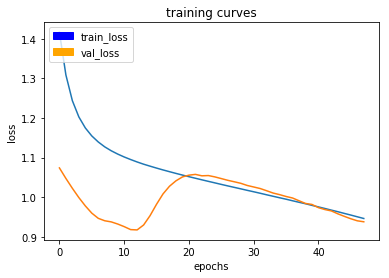

42/42 [==============================] - 62s - loss: 0.9463 - val_loss: 0.9379
Epoch 49/300
41/42 [============================>.] - ETA: 1s - loss: 0.9418

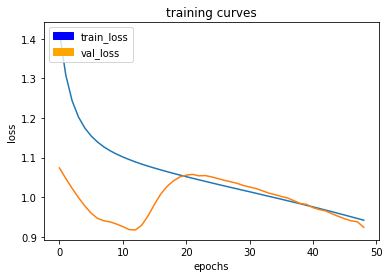

42/42 [==============================] - 62s - loss: 0.9419 - val_loss: 0.9238
Epoch 50/300
41/42 [============================>.] - ETA: 1s - loss: 0.9372

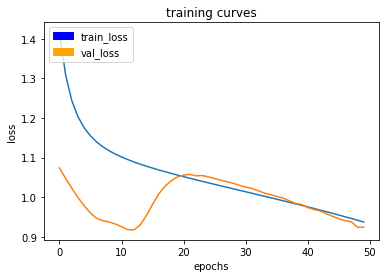

42/42 [==============================] - 62s - loss: 0.9370 - val_loss: 0.9244
Epoch 51/300
41/42 [============================>.] - ETA: 1s - loss: 0.9325

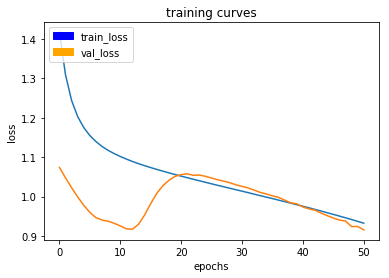

42/42 [==============================] - 62s - loss: 0.9329 - val_loss: 0.9155
Epoch 52/300
41/42 [============================>.] - ETA: 1s - loss: 0.9279

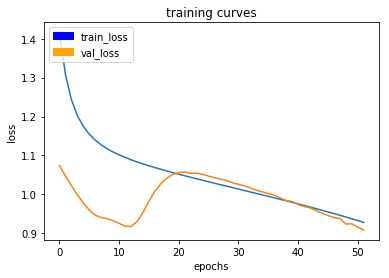

42/42 [==============================] - 62s - loss: 0.9279 - val_loss: 0.9086
Epoch 53/300
41/42 [============================>.] - ETA: 1s - loss: 0.9230

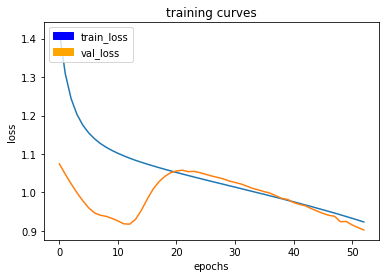

42/42 [==============================] - 61s - loss: 0.9232 - val_loss: 0.9024
Epoch 54/300
41/42 [============================>.] - ETA: 1s - loss: 0.9180

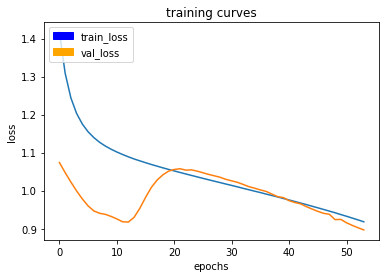

42/42 [==============================] - 62s - loss: 0.9183 - val_loss: 0.8967
Epoch 55/300
41/42 [============================>.] - ETA: 1s - loss: 0.9130

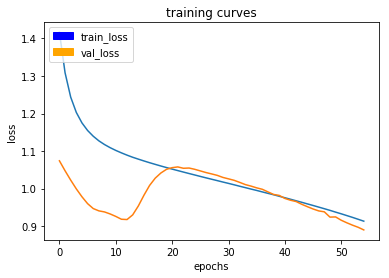

42/42 [==============================] - 61s - loss: 0.9131 - val_loss: 0.8897
Epoch 56/300
41/42 [============================>.] - ETA: 1s - loss: 0.9080

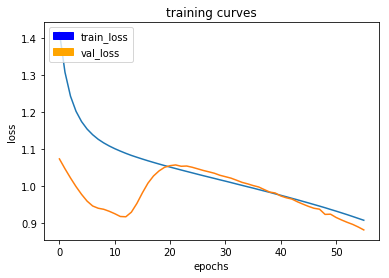

42/42 [==============================] - 62s - loss: 0.9078 - val_loss: 0.8818
Epoch 57/300
41/42 [============================>.] - ETA: 1s - loss: 0.9026

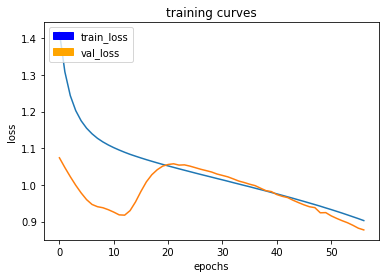

42/42 [==============================] - 62s - loss: 0.9026 - val_loss: 0.8771
Epoch 58/300
41/42 [============================>.] - ETA: 1s - loss: 0.8970

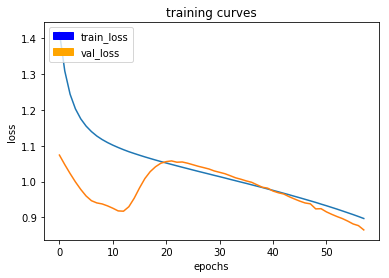

42/42 [==============================] - 62s - loss: 0.8971 - val_loss: 0.8652
Epoch 59/300
41/42 [============================>.] - ETA: 1s - loss: 0.8913

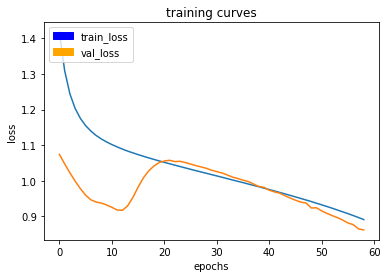

42/42 [==============================] - 62s - loss: 0.8914 - val_loss: 0.8624
Epoch 60/300
41/42 [============================>.] - ETA: 1s - loss: 0.8858

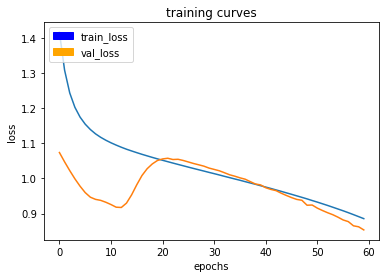

42/42 [==============================] - 62s - loss: 0.8852 - val_loss: 0.8535
Epoch 61/300
41/42 [============================>.] - ETA: 1s - loss: 0.8801

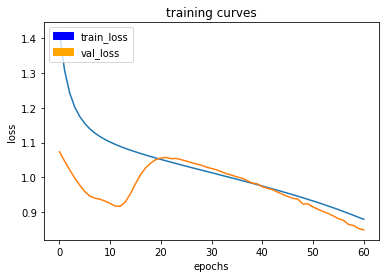

42/42 [==============================] - 62s - loss: 0.8802 - val_loss: 0.8496
Epoch 62/300
41/42 [============================>.] - ETA: 1s - loss: 0.8740

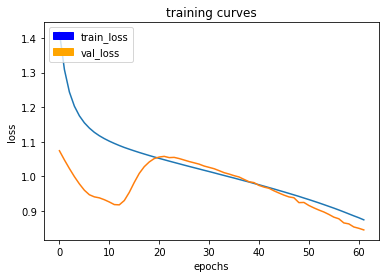

42/42 [==============================] - 62s - loss: 0.8742 - val_loss: 0.8449
Epoch 63/300
41/42 [============================>.] - ETA: 1s - loss: 0.8686

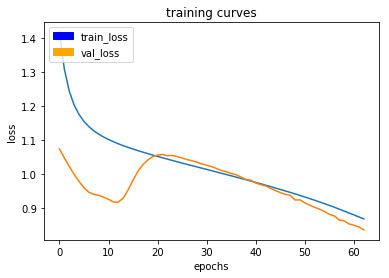

42/42 [==============================] - 62s - loss: 0.8684 - val_loss: 0.8360
Epoch 64/300
41/42 [============================>.] - ETA: 1s - loss: 0.8629

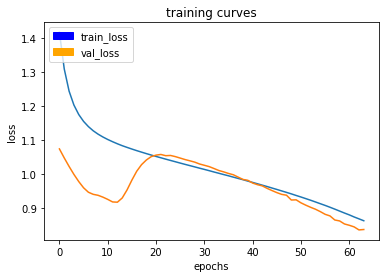

42/42 [==============================] - 62s - loss: 0.8629 - val_loss: 0.8372
Epoch 65/300
41/42 [============================>.] - ETA: 1s - loss: 0.8572

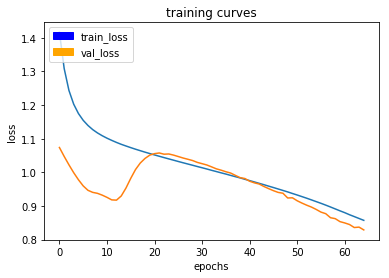

42/42 [==============================] - 62s - loss: 0.8575 - val_loss: 0.8289
Epoch 66/300
41/42 [============================>.] - ETA: 1s - loss: 0.8516

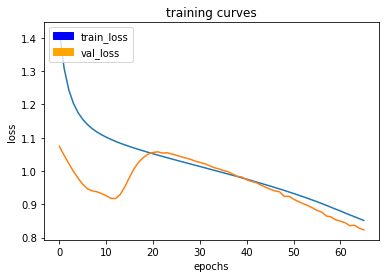

42/42 [==============================] - 61s - loss: 0.8518 - val_loss: 0.8232
Epoch 67/300
41/42 [============================>.] - ETA: 1s - loss: 0.8463

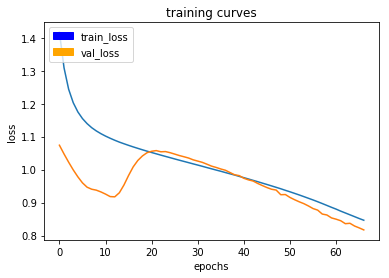

42/42 [==============================] - 62s - loss: 0.8467 - val_loss: 0.8171
Epoch 68/300
41/42 [============================>.] - ETA: 1s - loss: 0.8409

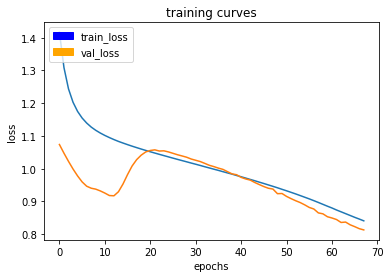

42/42 [==============================] - 62s - loss: 0.8410 - val_loss: 0.8132
Epoch 69/300
41/42 [============================>.] - ETA: 1s - loss: 0.8359

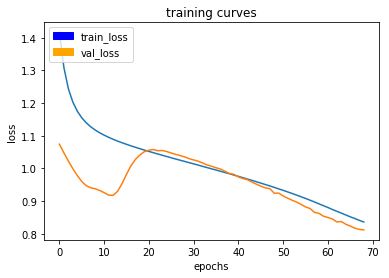

42/42 [==============================] - 62s - loss: 0.8358 - val_loss: 0.8116
Epoch 70/300
41/42 [============================>.] - ETA: 1s - loss: 0.8300

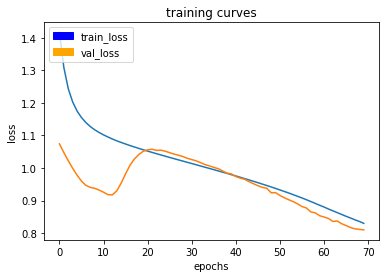

42/42 [==============================] - 62s - loss: 0.8302 - val_loss: 0.8099
Epoch 71/300
41/42 [============================>.] - ETA: 1s - loss: 0.8249

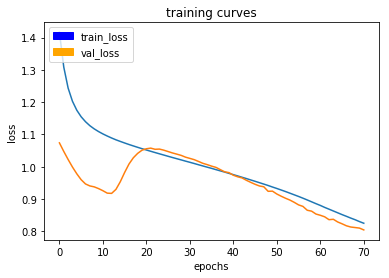

42/42 [==============================] - 61s - loss: 0.8250 - val_loss: 0.8042
Epoch 72/300
41/42 [============================>.] - ETA: 1s - loss: 0.8194

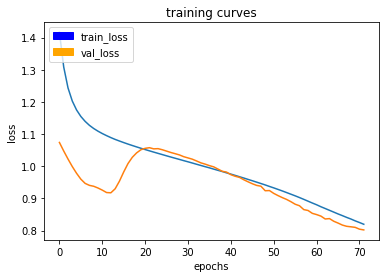

42/42 [==============================] - 62s - loss: 0.8197 - val_loss: 0.8020
Epoch 73/300
41/42 [============================>.] - ETA: 1s - loss: 0.8148

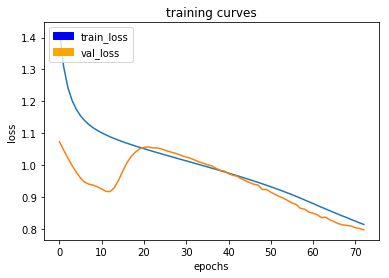

42/42 [==============================] - 62s - loss: 0.8139 - val_loss: 0.7974
Epoch 74/300
41/42 [============================>.] - ETA: 1s - loss: 0.8096

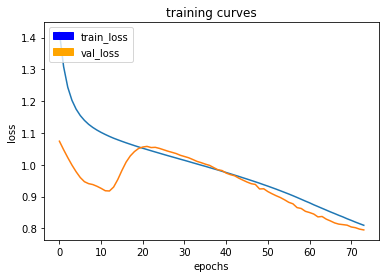

42/42 [==============================] - 61s - loss: 0.8095 - val_loss: 0.7950
Epoch 75/300
41/42 [============================>.] - ETA: 1s - loss: 0.8045

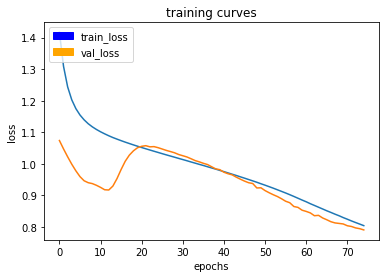

42/42 [==============================] - 62s - loss: 0.8047 - val_loss: 0.7911
Epoch 76/300
41/42 [============================>.] - ETA: 1s - loss: 0.7994

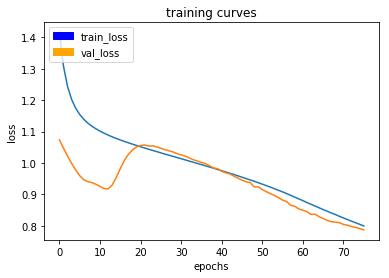

42/42 [==============================] - 61s - loss: 0.8000 - val_loss: 0.7869
Epoch 77/300
41/42 [============================>.] - ETA: 1s - loss: 0.7946

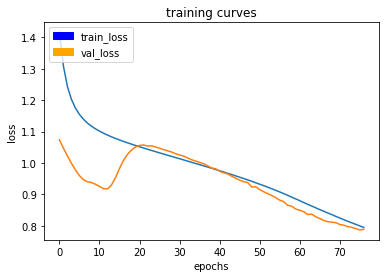

42/42 [==============================] - 62s - loss: 0.7951 - val_loss: 0.7886
Epoch 78/300
41/42 [============================>.] - ETA: 1s - loss: 0.7899

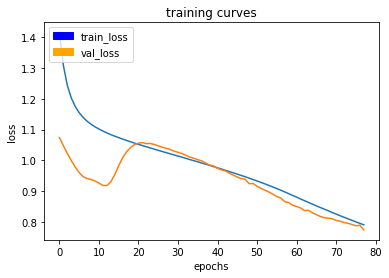

42/42 [==============================] - 62s - loss: 0.7902 - val_loss: 0.7734
Epoch 79/300
41/42 [============================>.] - ETA: 1s - loss: 0.7860

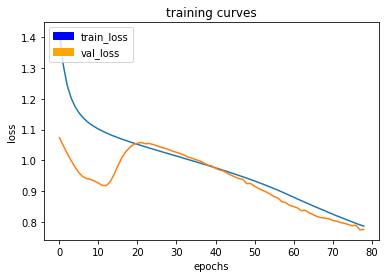

42/42 [==============================] - 62s - loss: 0.7853 - val_loss: 0.7751
Epoch 80/300
41/42 [============================>.] - ETA: 1s - loss: 0.7809

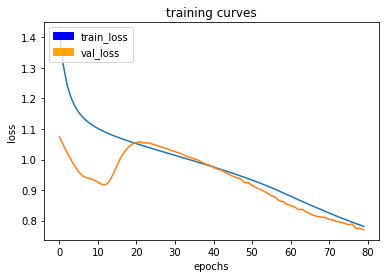

42/42 [==============================] - 61s - loss: 0.7816 - val_loss: 0.7695
Epoch 81/300
41/42 [============================>.] - ETA: 1s - loss: 0.7765

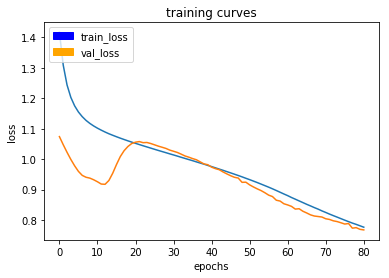

42/42 [==============================] - 61s - loss: 0.7766 - val_loss: 0.7676
Epoch 82/300
41/42 [============================>.] - ETA: 1s - loss: 0.7720

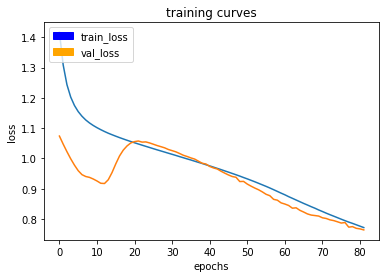

42/42 [==============================] - 62s - loss: 0.7719 - val_loss: 0.7642
Epoch 83/300
41/42 [============================>.] - ETA: 1s - loss: 0.7683

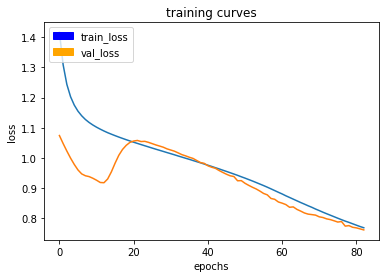

42/42 [==============================] - 61s - loss: 0.7674 - val_loss: 0.7608
Epoch 84/300
41/42 [============================>.] - ETA: 1s - loss: 0.7633

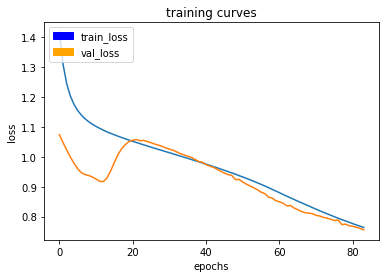

42/42 [==============================] - 62s - loss: 0.7645 - val_loss: 0.7556
Epoch 85/300
41/42 [============================>.] - ETA: 1s - loss: 0.7595

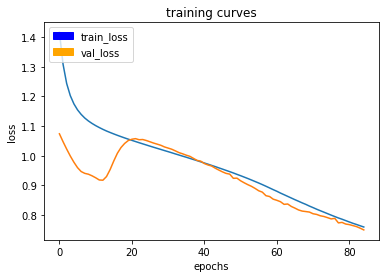

42/42 [==============================] - 62s - loss: 0.7595 - val_loss: 0.7497
Epoch 86/300
41/42 [============================>.] - ETA: 1s - loss: 0.7555

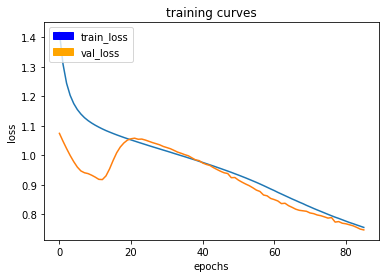

42/42 [==============================] - 62s - loss: 0.7549 - val_loss: 0.7468
Epoch 87/300
41/42 [============================>.] - ETA: 1s - loss: 0.7509

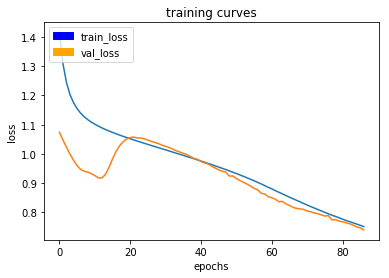

42/42 [==============================] - 62s - loss: 0.7505 - val_loss: 0.7395
Epoch 88/300
41/42 [============================>.] - ETA: 1s - loss: 0.7469

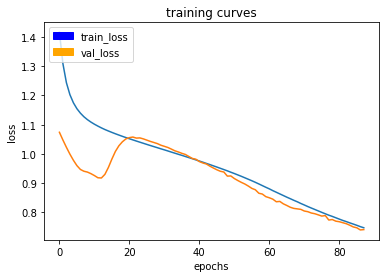

42/42 [==============================] - 62s - loss: 0.7470 - val_loss: 0.7406
Epoch 89/300
41/42 [============================>.] - ETA: 1s - loss: 0.7427

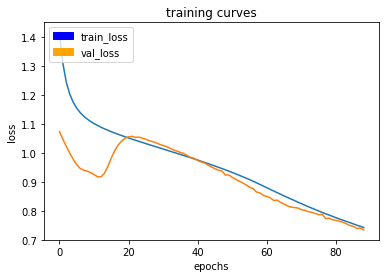

42/42 [==============================] - 62s - loss: 0.7428 - val_loss: 0.7346
Epoch 90/300
41/42 [============================>.] - ETA: 1s - loss: 0.7387

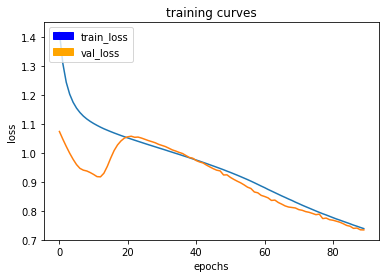

42/42 [==============================] - 62s - loss: 0.7390 - val_loss: 0.7342
Epoch 91/300
41/42 [============================>.] - ETA: 1s - loss: 0.7350

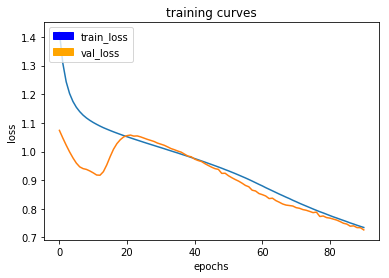

42/42 [==============================] - 61s - loss: 0.7350 - val_loss: 0.7265
Epoch 92/300
41/42 [============================>.] - ETA: 1s - loss: 0.7305

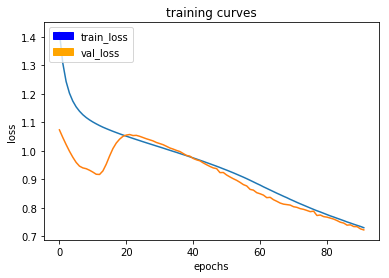

42/42 [==============================] - 62s - loss: 0.7307 - val_loss: 0.7228
Epoch 93/300
41/42 [============================>.] - ETA: 1s - loss: 0.7270

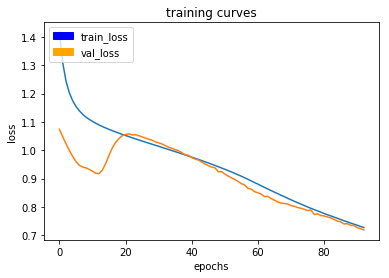

42/42 [==============================] - 61s - loss: 0.7267 - val_loss: 0.7184
Epoch 94/300
41/42 [============================>.] - ETA: 1s - loss: 0.7225

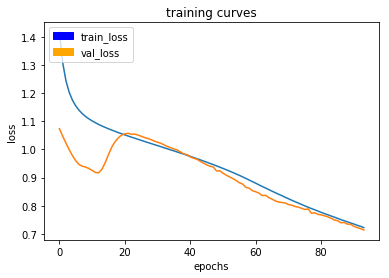

42/42 [==============================] - 62s - loss: 0.7221 - val_loss: 0.7142
Epoch 95/300
41/42 [============================>.] - ETA: 1s - loss: 0.7185

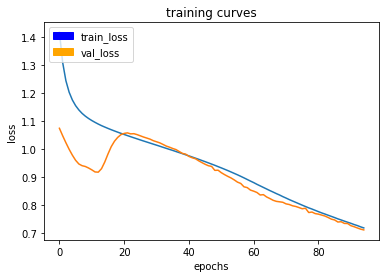

42/42 [==============================] - 62s - loss: 0.7182 - val_loss: 0.7113
Epoch 96/300
41/42 [============================>.] - ETA: 1s - loss: 0.7148

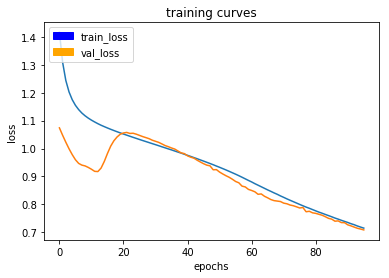

42/42 [==============================] - 62s - loss: 0.7145 - val_loss: 0.7083
Epoch 97/300
41/42 [============================>.] - ETA: 1s - loss: 0.7104

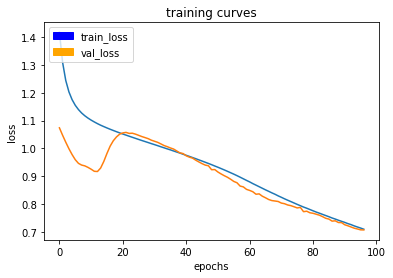

42/42 [==============================] - 62s - loss: 0.7107 - val_loss: 0.7080
Epoch 98/300
41/42 [============================>.] - ETA: 1s - loss: 0.7064

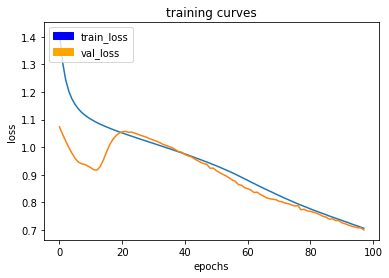

42/42 [==============================] - 61s - loss: 0.7066 - val_loss: 0.7004
Epoch 99/300
41/42 [============================>.] - ETA: 1s - loss: 0.7032

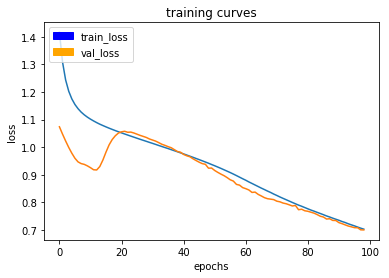

42/42 [==============================] - 62s - loss: 0.7022 - val_loss: 0.7001
Epoch 100/300
41/42 [============================>.] - ETA: 1s - loss: 0.6988

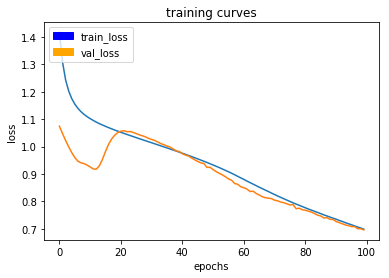

42/42 [==============================] - 62s - loss: 0.6986 - val_loss: 0.6959
Epoch 101/300
41/42 [============================>.] - ETA: 1s - loss: 0.6949

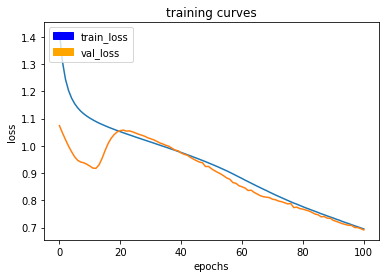

42/42 [==============================] - 62s - loss: 0.6950 - val_loss: 0.6914
Epoch 102/300
41/42 [============================>.] - ETA: 1s - loss: 0.6910

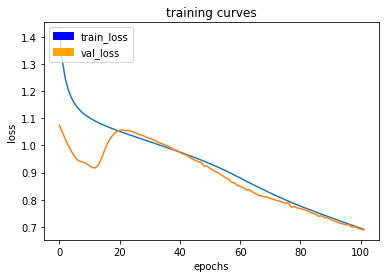

42/42 [==============================] - 62s - loss: 0.6915 - val_loss: 0.6890
Epoch 103/300
41/42 [============================>.] - ETA: 1s - loss: 0.6871

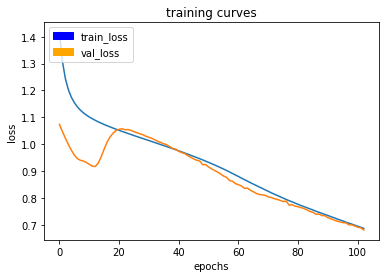

42/42 [==============================] - 62s - loss: 0.6871 - val_loss: 0.6814
Epoch 104/300
41/42 [============================>.] - ETA: 1s - loss: 0.6831

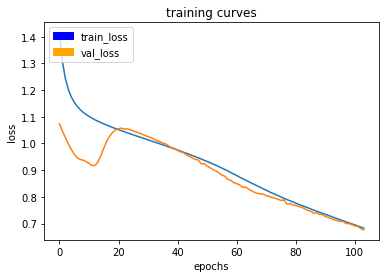

42/42 [==============================] - 61s - loss: 0.6833 - val_loss: 0.6764
Epoch 105/300
41/42 [============================>.] - ETA: 1s - loss: 0.6795

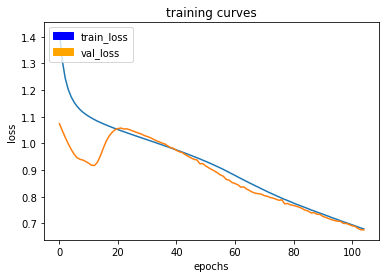

42/42 [==============================] - 62s - loss: 0.6792 - val_loss: 0.6759
Epoch 106/300
41/42 [============================>.] - ETA: 1s - loss: 0.6754

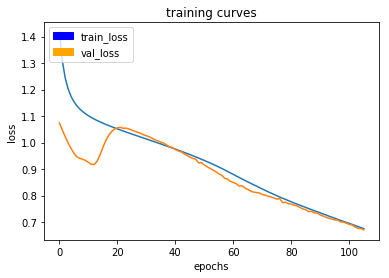

42/42 [==============================] - 61s - loss: 0.6754 - val_loss: 0.6705
Epoch 107/300
41/42 [============================>.] - ETA: 1s - loss: 0.6722

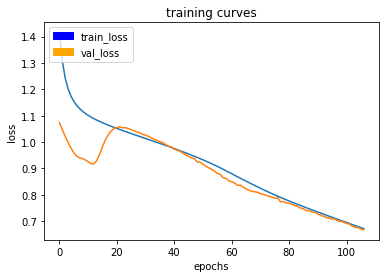

42/42 [==============================] - 62s - loss: 0.6713 - val_loss: 0.6669
Epoch 108/300
41/42 [============================>.] - ETA: 1s - loss: 0.6682

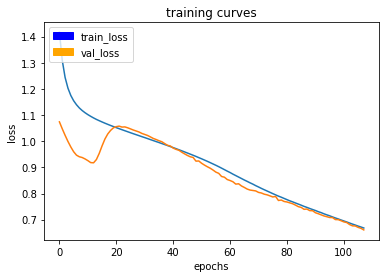

42/42 [==============================] - 62s - loss: 0.6678 - val_loss: 0.6608
Epoch 109/300
41/42 [============================>.] - ETA: 1s - loss: 0.6642

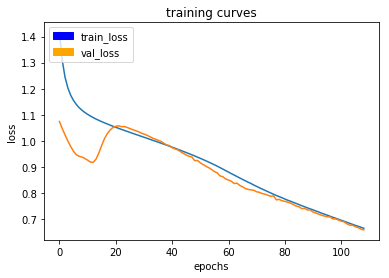

42/42 [==============================] - 62s - loss: 0.6644 - val_loss: 0.6579
Epoch 110/300
41/42 [============================>.] - ETA: 1s - loss: 0.6605

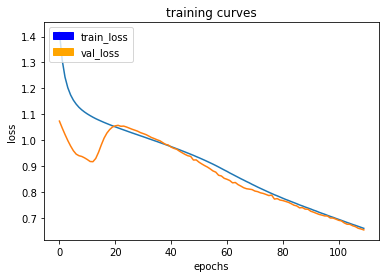

42/42 [==============================] - 62s - loss: 0.6603 - val_loss: 0.6544
Epoch 111/300
41/42 [============================>.] - ETA: 1s - loss: 0.6570

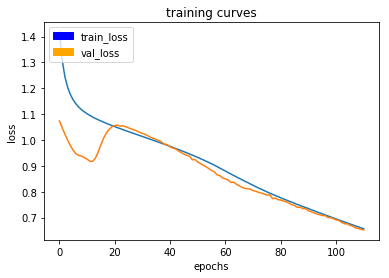

42/42 [==============================] - 62s - loss: 0.6568 - val_loss: 0.6525
Epoch 112/300
41/42 [============================>.] - ETA: 1s - loss: 0.6528

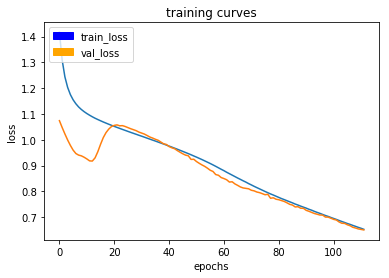

42/42 [==============================] - 61s - loss: 0.6529 - val_loss: 0.6506
Epoch 113/300
41/42 [============================>.] - ETA: 1s - loss: 0.6492

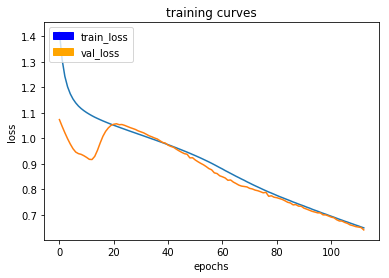

42/42 [==============================] - 62s - loss: 0.6495 - val_loss: 0.6412
Epoch 114/300
41/42 [============================>.] - ETA: 1s - loss: 0.6454

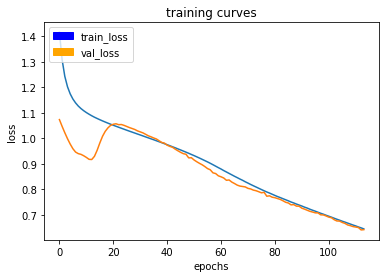

42/42 [==============================] - 62s - loss: 0.6451 - val_loss: 0.6422
Epoch 115/300
41/42 [============================>.] - ETA: 1s - loss: 0.6418

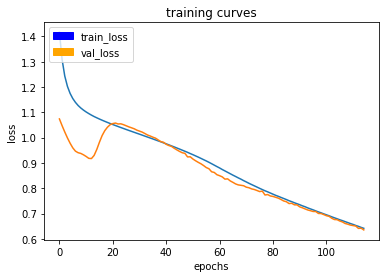

42/42 [==============================] - 62s - loss: 0.6411 - val_loss: 0.6353
Epoch 116/300
41/42 [============================>.] - ETA: 1s - loss: 0.6378

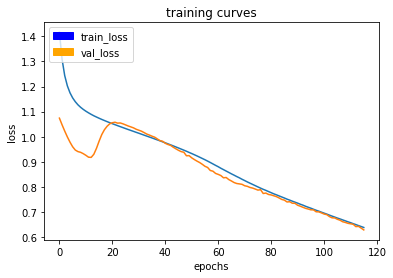

42/42 [==============================] - 62s - loss: 0.6376 - val_loss: 0.6280
Epoch 117/300
41/42 [============================>.] - ETA: 1s - loss: 0.6341

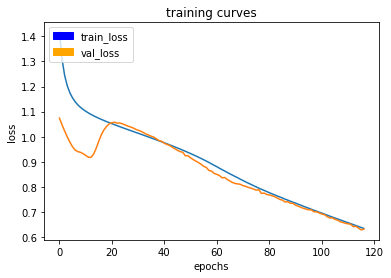

42/42 [==============================] - 62s - loss: 0.6338 - val_loss: 0.6312
Epoch 118/300
41/42 [============================>.] - ETA: 1s - loss: 0.6298

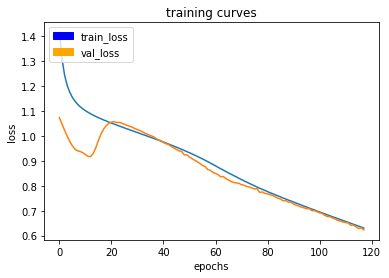

42/42 [==============================] - 62s - loss: 0.6306 - val_loss: 0.6227
Epoch 119/300
41/42 [============================>.] - ETA: 1s - loss: 0.6268

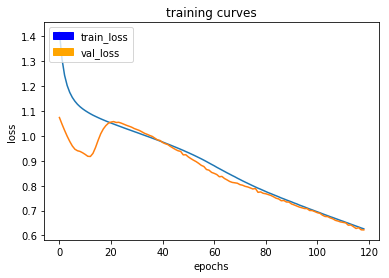

42/42 [==============================] - 62s - loss: 0.6264 - val_loss: 0.6223
Epoch 120/300
41/42 [============================>.] - ETA: 1s - loss: 0.6229

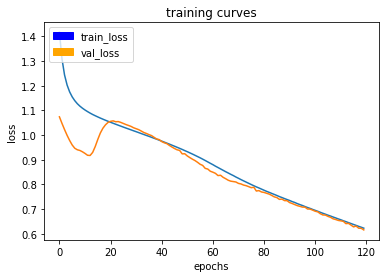

42/42 [==============================] - 61s - loss: 0.6224 - val_loss: 0.6157
Epoch 121/300
41/42 [============================>.] - ETA: 1s - loss: 0.6186

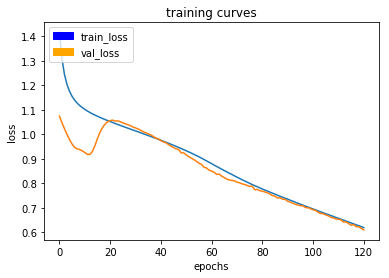

42/42 [==============================] - 62s - loss: 0.6189 - val_loss: 0.6094
Epoch 122/300
41/42 [============================>.] - ETA: 1s - loss: 0.6150

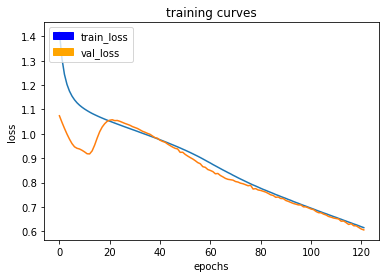

42/42 [==============================] - 62s - loss: 0.6151 - val_loss: 0.6056
Epoch 123/300
41/42 [============================>.] - ETA: 1s - loss: 0.6110

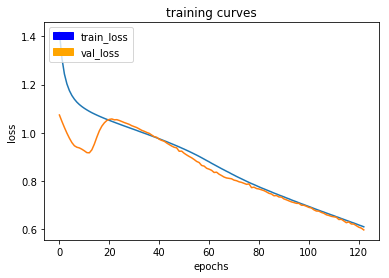

42/42 [==============================] - 62s - loss: 0.6110 - val_loss: 0.5982
Epoch 124/300
41/42 [============================>.] - ETA: 1s - loss: 0.6070

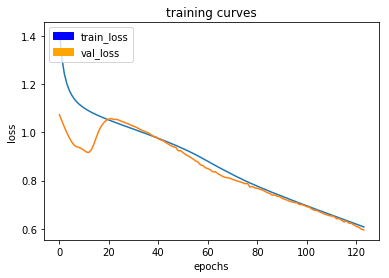

42/42 [==============================] - 62s - loss: 0.6077 - val_loss: 0.5949
Epoch 125/300
41/42 [============================>.] - ETA: 1s - loss: 0.6033

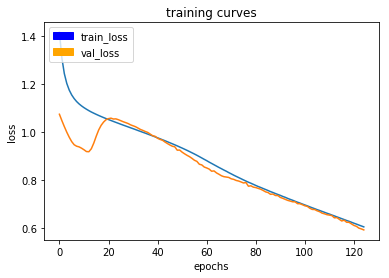

42/42 [==============================] - 62s - loss: 0.6036 - val_loss: 0.5907
Epoch 126/300
41/42 [============================>.] - ETA: 1s - loss: 0.5999

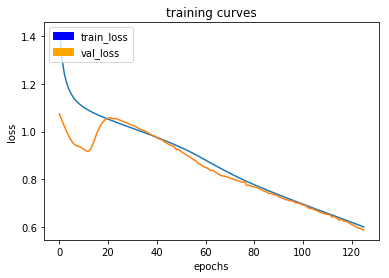

42/42 [==============================] - 62s - loss: 0.5984 - val_loss: 0.5869
Epoch 127/300
41/42 [============================>.] - ETA: 1s - loss: 0.5958

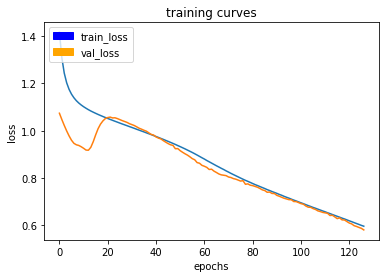

42/42 [==============================] - 62s - loss: 0.5962 - val_loss: 0.5802
Epoch 128/300
41/42 [============================>.] - ETA: 1s - loss: 0.5918

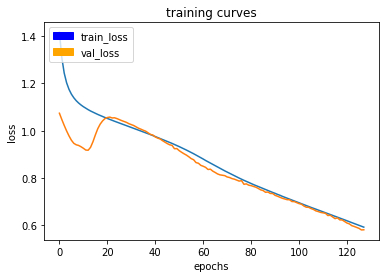

42/42 [==============================] - 61s - loss: 0.5923 - val_loss: 0.5808
Epoch 129/300
41/42 [============================>.] - ETA: 1s - loss: 0.5880

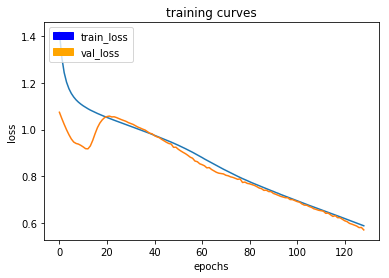

42/42 [==============================] - 61s - loss: 0.5877 - val_loss: 0.5702
Epoch 130/300
41/42 [============================>.] - ETA: 1s - loss: 0.5836

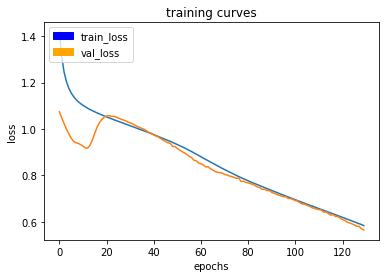

42/42 [==============================] - 62s - loss: 0.5830 - val_loss: 0.5649
Epoch 131/300
41/42 [============================>.] - ETA: 1s - loss: 0.5790

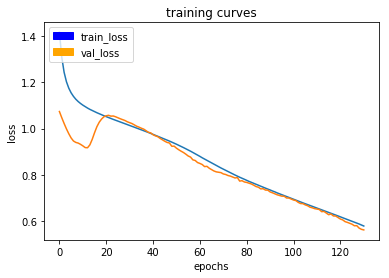

42/42 [==============================] - 62s - loss: 0.5795 - val_loss: 0.5623
Epoch 132/300
41/42 [============================>.] - ETA: 1s - loss: 0.5749

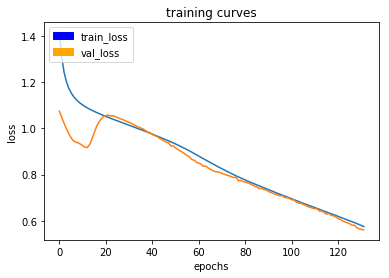

42/42 [==============================] - 61s - loss: 0.5749 - val_loss: 0.5603
Epoch 133/300
41/42 [============================>.] - ETA: 1s - loss: 0.5703

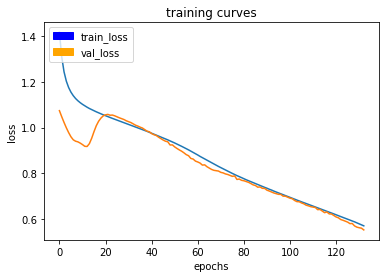

42/42 [==============================] - 61s - loss: 0.5709 - val_loss: 0.5527
Epoch 134/300
41/42 [============================>.] - ETA: 1s - loss: 0.5669

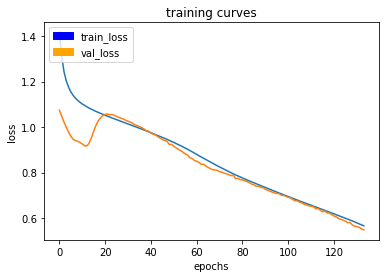

42/42 [==============================] - 62s - loss: 0.5663 - val_loss: 0.5484
Epoch 135/300
41/42 [============================>.] - ETA: 1s - loss: 0.5620

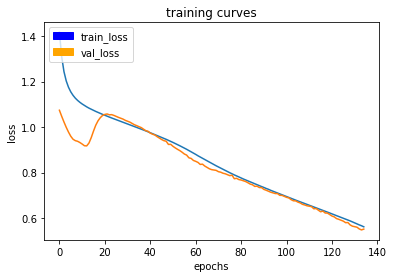

42/42 [==============================] - 61s - loss: 0.5620 - val_loss: 0.5520
Epoch 136/300
41/42 [============================>.] - ETA: 1s - loss: 0.5578

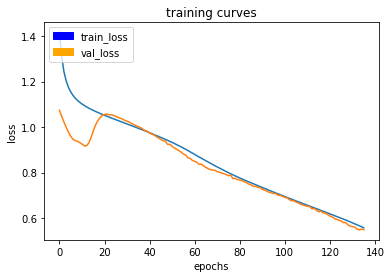

42/42 [==============================] - 61s - loss: 0.5578 - val_loss: 0.5494
Epoch 137/300
41/42 [============================>.] - ETA: 1s - loss: 0.5535

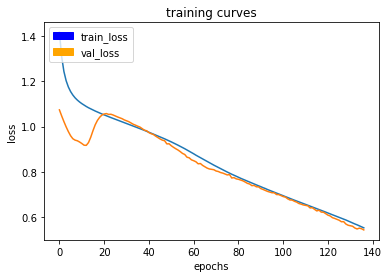

42/42 [==============================] - 61s - loss: 0.5532 - val_loss: 0.5442
Epoch 138/300
41/42 [============================>.] - ETA: 1s - loss: 0.5499

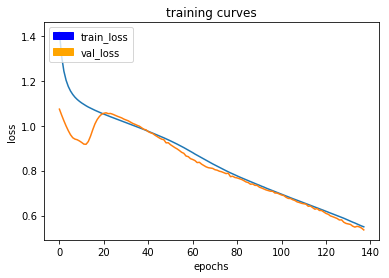

42/42 [==============================] - 62s - loss: 0.5494 - val_loss: 0.5359
Epoch 139/300
41/42 [============================>.] - ETA: 1s - loss: 0.5455

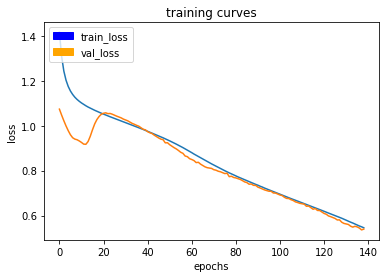

42/42 [==============================] - 62s - loss: 0.5453 - val_loss: 0.5396
Epoch 140/300
41/42 [============================>.] - ETA: 1s - loss: 0.5418

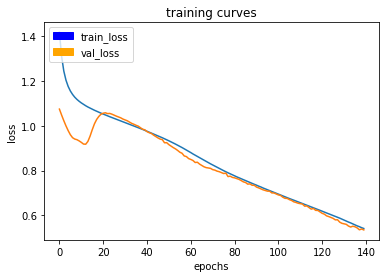

42/42 [==============================] - 62s - loss: 0.5418 - val_loss: 0.5354
Epoch 141/300
41/42 [============================>.] - ETA: 1s - loss: 0.5380

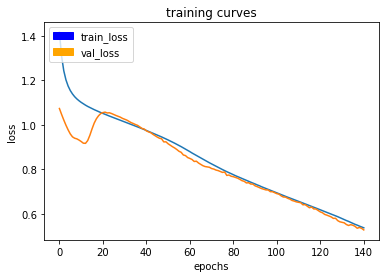

42/42 [==============================] - 61s - loss: 0.5377 - val_loss: 0.5284
Epoch 142/300
41/42 [============================>.] - ETA: 1s - loss: 0.5345

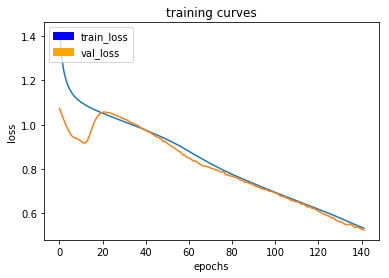

42/42 [==============================] - 62s - loss: 0.5340 - val_loss: 0.5259
Epoch 143/300
41/42 [============================>.] - ETA: 1s - loss: 0.5306

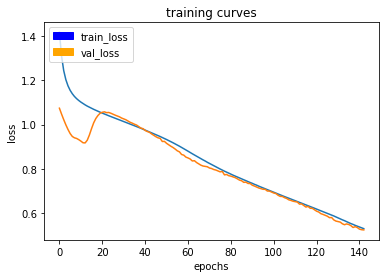

42/42 [==============================] - 62s - loss: 0.5309 - val_loss: 0.5250
Epoch 144/300
41/42 [============================>.] - ETA: 1s - loss: 0.5266

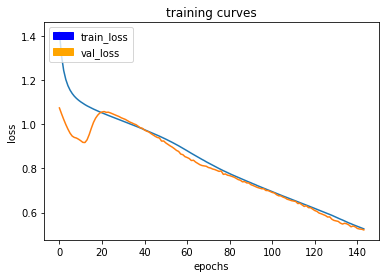

42/42 [==============================] - 62s - loss: 0.5266 - val_loss: 0.5218
Epoch 145/300
41/42 [============================>.] - ETA: 1s - loss: 0.5234

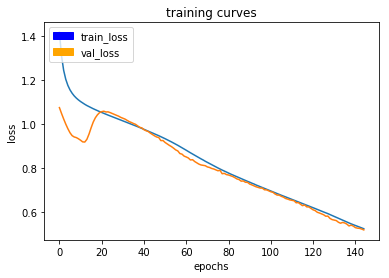

42/42 [==============================] - 62s - loss: 0.5232 - val_loss: 0.5179
Epoch 146/300
41/42 [============================>.] - ETA: 1s - loss: 0.5200

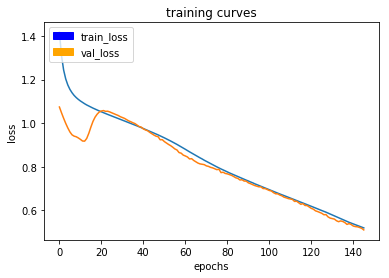

42/42 [==============================] - 62s - loss: 0.5197 - val_loss: 0.5107
Epoch 147/300
41/42 [============================>.] - ETA: 1s - loss: 0.5167

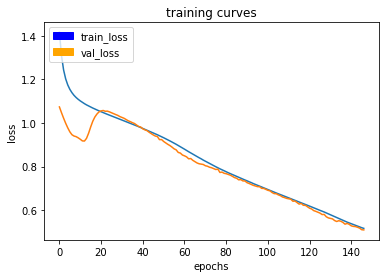

42/42 [==============================] - 61s - loss: 0.5170 - val_loss: 0.5097
Epoch 148/300
41/42 [============================>.] - ETA: 1s - loss: 0.5133

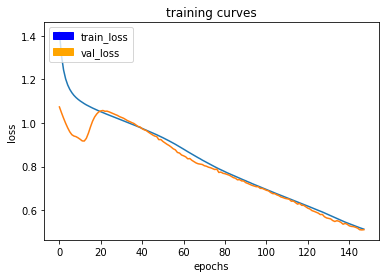

42/42 [==============================] - 62s - loss: 0.5133 - val_loss: 0.5106
Epoch 149/300
41/42 [============================>.] - ETA: 1s - loss: 0.5099

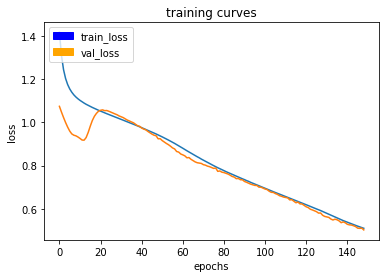

42/42 [==============================] - 62s - loss: 0.5100 - val_loss: 0.5024
Epoch 150/300
41/42 [============================>.] - ETA: 1s - loss: 0.5061

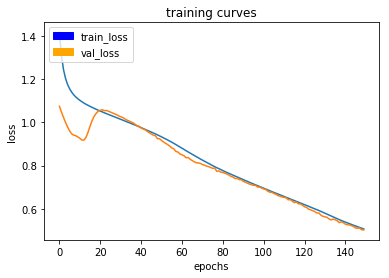

42/42 [==============================] - 62s - loss: 0.5065 - val_loss: 0.5020
Epoch 151/300
41/42 [============================>.] - ETA: 1s - loss: 0.5034

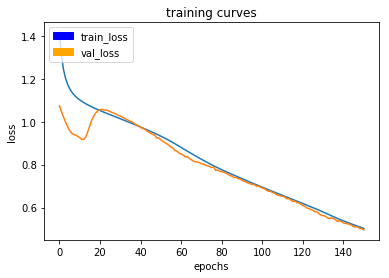

42/42 [==============================] - 62s - loss: 0.5028 - val_loss: 0.4960
Epoch 152/300
41/42 [============================>.] - ETA: 1s - loss: 0.4996

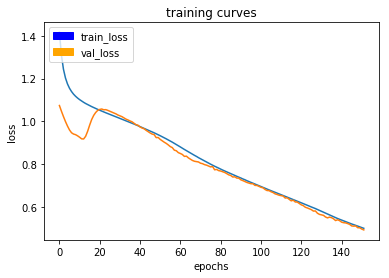

42/42 [==============================] - 62s - loss: 0.4999 - val_loss: 0.4921
Epoch 153/300
41/42 [============================>.] - ETA: 1s - loss: 0.4967

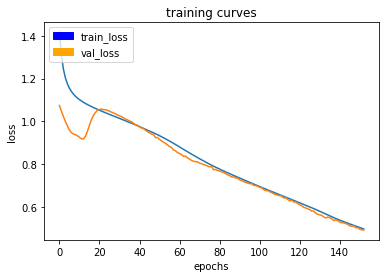

42/42 [==============================] - 62s - loss: 0.4959 - val_loss: 0.4922
Epoch 154/300
41/42 [============================>.] - ETA: 1s - loss: 0.4930

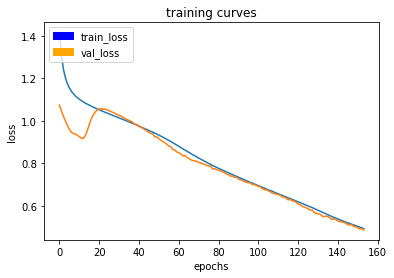

42/42 [==============================] - 62s - loss: 0.4932 - val_loss: 0.4868
Epoch 155/300
41/42 [============================>.] - ETA: 1s - loss: 0.4907

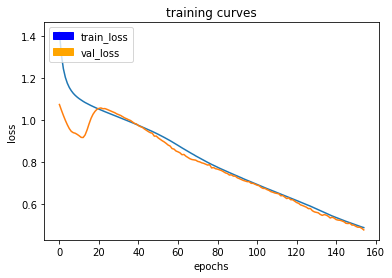

42/42 [==============================] - 62s - loss: 0.4898 - val_loss: 0.4793
Epoch 156/300
41/42 [============================>.] - ETA: 1s - loss: 0.4871

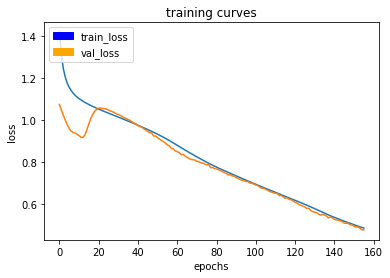

42/42 [==============================] - 61s - loss: 0.4872 - val_loss: 0.4784
Epoch 157/300
41/42 [============================>.] - ETA: 1s - loss: 0.4838

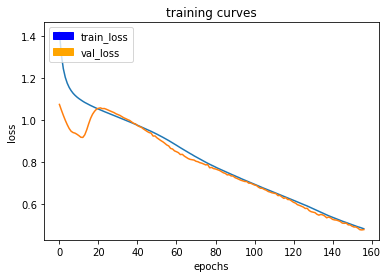

42/42 [==============================] - 62s - loss: 0.4841 - val_loss: 0.4799
Epoch 158/300
41/42 [============================>.] - ETA: 1s - loss: 0.4800

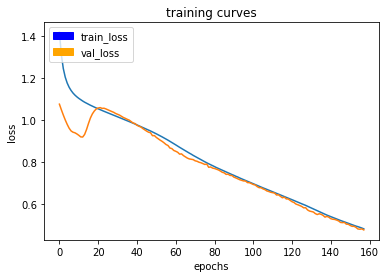

42/42 [==============================] - 62s - loss: 0.4802 - val_loss: 0.4750
Epoch 159/300
41/42 [============================>.] - ETA: 1s - loss: 0.4771

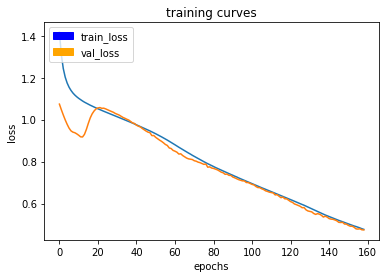

42/42 [==============================] - 62s - loss: 0.4768 - val_loss: 0.4744
Epoch 160/300
41/42 [============================>.] - ETA: 1s - loss: 0.4741

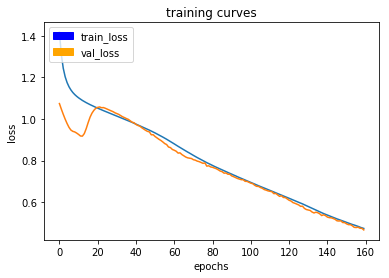

42/42 [==============================] - 63s - loss: 0.4736 - val_loss: 0.4669
Epoch 161/300
41/42 [============================>.] - ETA: 1s - loss: 0.4709

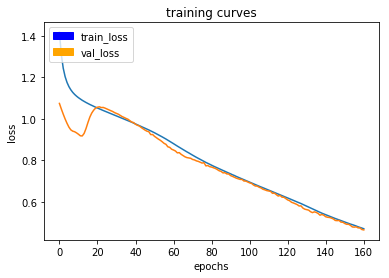

42/42 [==============================] - 62s - loss: 0.4707 - val_loss: 0.4650
Epoch 162/300
41/42 [============================>.] - ETA: 1s - loss: 0.4672

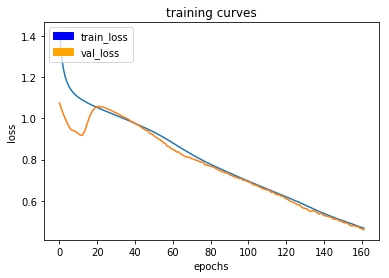

42/42 [==============================] - 62s - loss: 0.4674 - val_loss: 0.4588
Epoch 163/300
41/42 [============================>.] - ETA: 1s - loss: 0.4649

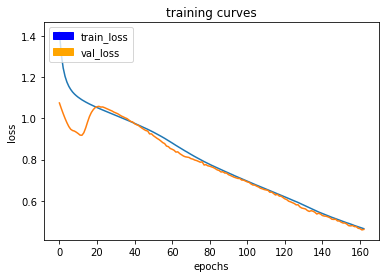

42/42 [==============================] - 62s - loss: 0.4649 - val_loss: 0.4611
Epoch 164/300
41/42 [============================>.] - ETA: 1s - loss: 0.4609

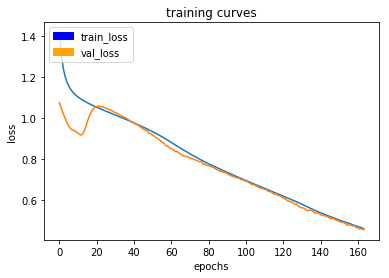

42/42 [==============================] - 61s - loss: 0.4607 - val_loss: 0.4550
Epoch 165/300
41/42 [============================>.] - ETA: 1s - loss: 0.4574

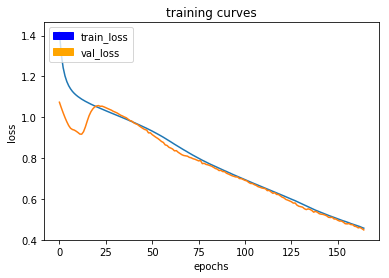

42/42 [==============================] - 62s - loss: 0.4573 - val_loss: 0.4489
Epoch 166/300
41/42 [============================>.] - ETA: 1s - loss: 0.4547

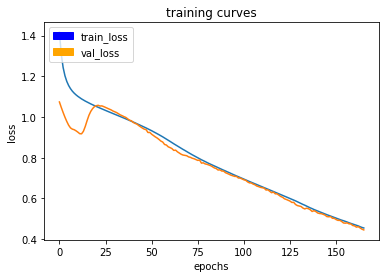

42/42 [==============================] - 61s - loss: 0.4546 - val_loss: 0.4452
Epoch 167/300
41/42 [============================>.] - ETA: 1s - loss: 0.4510

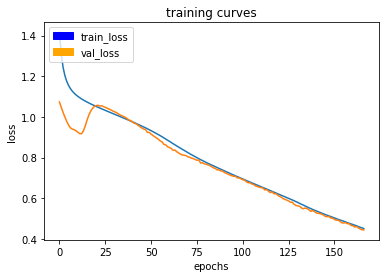

42/42 [==============================] - 61s - loss: 0.4507 - val_loss: 0.4444
Epoch 168/300
41/42 [============================>.] - ETA: 1s - loss: 0.4475

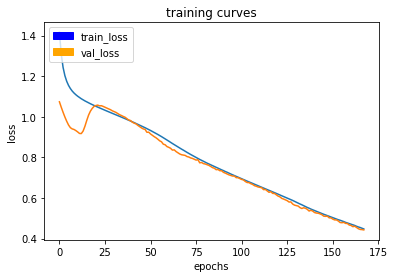

42/42 [==============================] - 62s - loss: 0.4477 - val_loss: 0.4428
Epoch 169/300
41/42 [============================>.] - ETA: 1s - loss: 0.4440

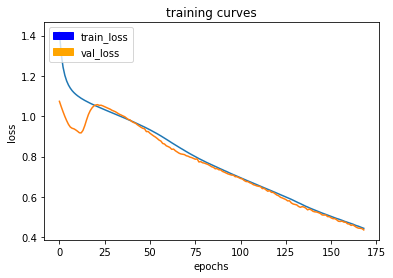

42/42 [==============================] - 62s - loss: 0.4443 - val_loss: 0.4363
Epoch 170/300
41/42 [============================>.] - ETA: 1s - loss: 0.4412

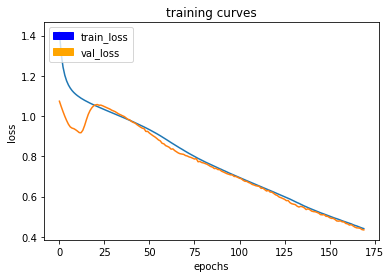

42/42 [==============================] - 62s - loss: 0.4416 - val_loss: 0.4348
Epoch 171/300
41/42 [============================>.] - ETA: 1s - loss: 0.4378

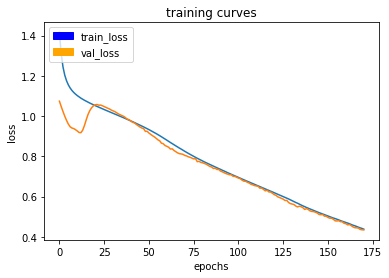

42/42 [==============================] - 62s - loss: 0.4374 - val_loss: 0.4340
Epoch 172/300
41/42 [============================>.] - ETA: 1s - loss: 0.4352

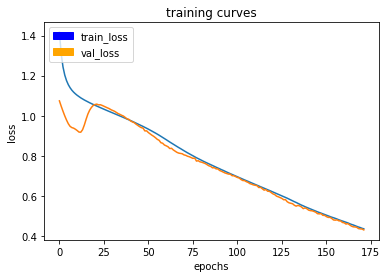

42/42 [==============================] - 61s - loss: 0.4352 - val_loss: 0.4296
Epoch 173/300
41/42 [============================>.] - ETA: 1s - loss: 0.4318

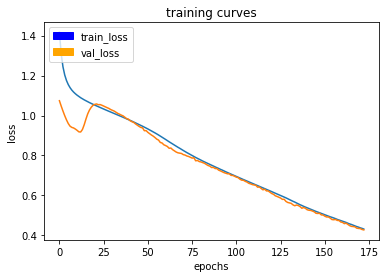

42/42 [==============================] - 61s - loss: 0.4311 - val_loss: 0.4274
Epoch 174/300
41/42 [============================>.] - ETA: 1s - loss: 0.4289

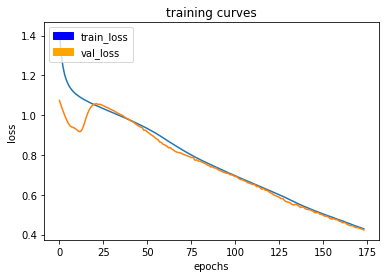

42/42 [==============================] - 62s - loss: 0.4288 - val_loss: 0.4232
Epoch 175/300
41/42 [============================>.] - ETA: 1s - loss: 0.4255

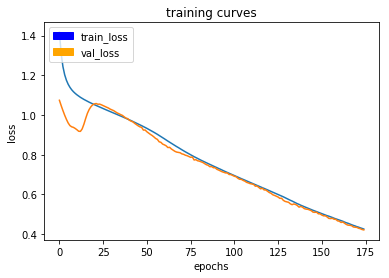

42/42 [==============================] - 61s - loss: 0.4255 - val_loss: 0.4212
Epoch 176/300
41/42 [============================>.] - ETA: 1s - loss: 0.4221

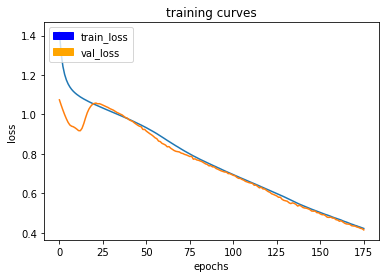

42/42 [==============================] - 62s - loss: 0.4226 - val_loss: 0.4149
Epoch 177/300
41/42 [============================>.] - ETA: 1s - loss: 0.4201

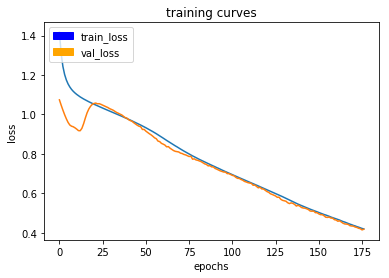

42/42 [==============================] - 61s - loss: 0.4199 - val_loss: 0.4184
Epoch 178/300
41/42 [============================>.] - ETA: 1s - loss: 0.4163

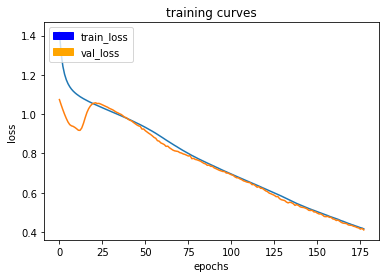

42/42 [==============================] - 61s - loss: 0.4164 - val_loss: 0.4109
Epoch 179/300
41/42 [============================>.] - ETA: 1s - loss: 0.4132

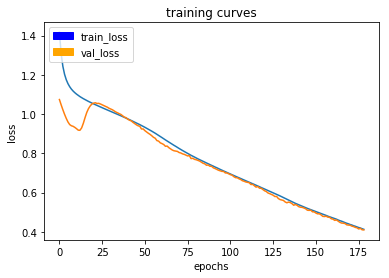

42/42 [==============================] - 62s - loss: 0.4133 - val_loss: 0.4102
Epoch 180/300
41/42 [============================>.] - ETA: 1s - loss: 0.4106

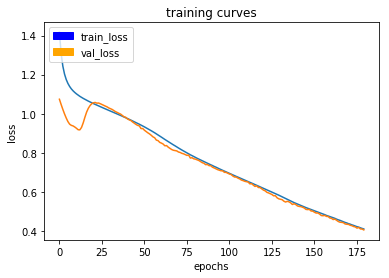

42/42 [==============================] - 62s - loss: 0.4105 - val_loss: 0.4058
Epoch 181/300
41/42 [============================>.] - ETA: 1s - loss: 0.4079

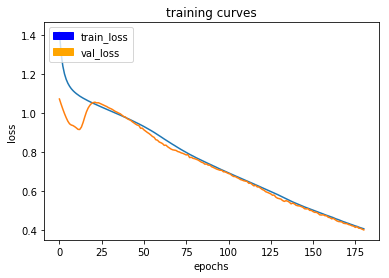

42/42 [==============================] - 62s - loss: 0.4080 - val_loss: 0.4020
Epoch 182/300
41/42 [============================>.] - ETA: 1s - loss: 0.4050

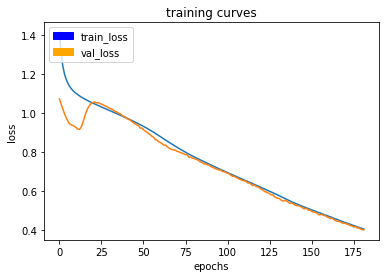

42/42 [==============================] - 62s - loss: 0.4049 - val_loss: 0.4003
Epoch 183/300
41/42 [============================>.] - ETA: 1s - loss: 0.4016

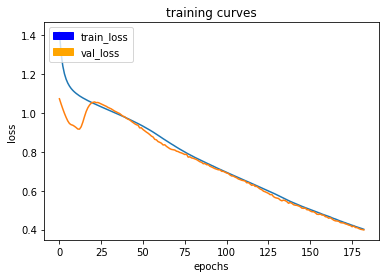

42/42 [==============================] - 62s - loss: 0.4015 - val_loss: 0.3985
Epoch 184/300
41/42 [============================>.] - ETA: 1s - loss: 0.3989

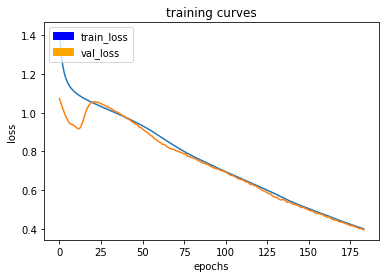

42/42 [==============================] - 61s - loss: 0.3988 - val_loss: 0.3937
Epoch 185/300
41/42 [============================>.] - ETA: 1s - loss: 0.3960

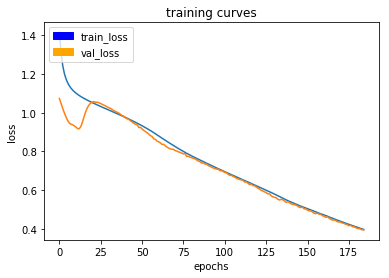

42/42 [==============================] - 62s - loss: 0.3957 - val_loss: 0.3946
Epoch 186/300
41/42 [============================>.] - ETA: 1s - loss: 0.3931

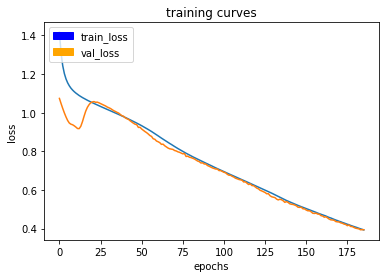

42/42 [==============================] - 62s - loss: 0.3929 - val_loss: 0.3939
Epoch 187/300
41/42 [============================>.] - ETA: 1s - loss: 0.3902

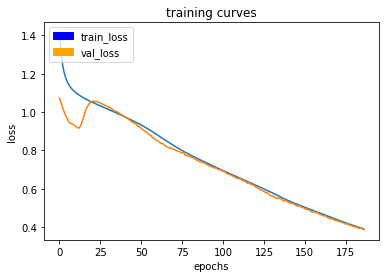

42/42 [==============================] - 62s - loss: 0.3906 - val_loss: 0.3855
Epoch 188/300
41/42 [============================>.] - ETA: 1s - loss: 0.3875

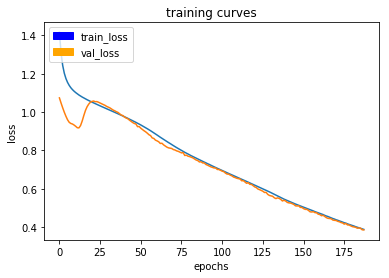

42/42 [==============================] - 62s - loss: 0.3874 - val_loss: 0.3848
Epoch 189/300
41/42 [============================>.] - ETA: 1s - loss: 0.3845

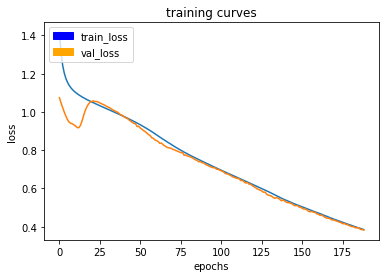

42/42 [==============================] - 61s - loss: 0.3847 - val_loss: 0.3831
Epoch 190/300
41/42 [============================>.] - ETA: 1s - loss: 0.3816

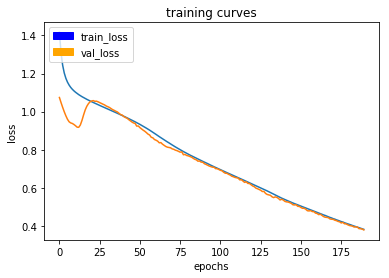

42/42 [==============================] - 61s - loss: 0.3816 - val_loss: 0.3786
Epoch 191/300
41/42 [============================>.] - ETA: 1s - loss: 0.3789

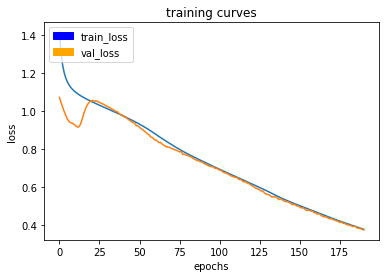

42/42 [==============================] - 61s - loss: 0.3792 - val_loss: 0.3758
Epoch 192/300
41/42 [============================>.] - ETA: 1s - loss: 0.3763

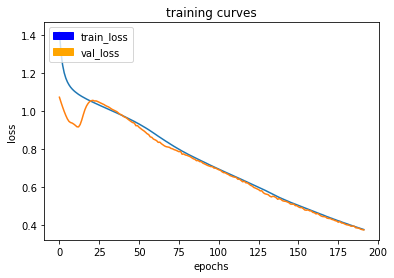

42/42 [==============================] - 62s - loss: 0.3766 - val_loss: 0.3744
Epoch 193/300
41/42 [============================>.] - ETA: 1s - loss: 0.3736

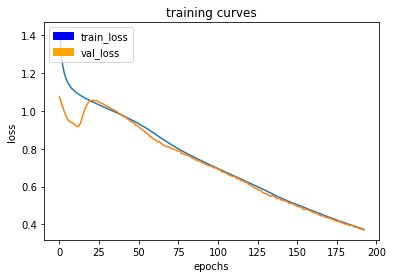

42/42 [==============================] - 61s - loss: 0.3731 - val_loss: 0.3703
Epoch 194/300
41/42 [============================>.] - ETA: 1s - loss: 0.3709

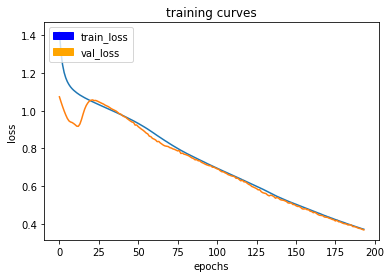

42/42 [==============================] - 61s - loss: 0.3717 - val_loss: 0.3675
Epoch 195/300
41/42 [============================>.] - ETA: 1s - loss: 0.3683

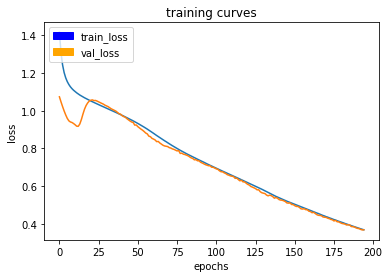

42/42 [==============================] - 62s - loss: 0.3681 - val_loss: 0.3681
Epoch 196/300
41/42 [============================>.] - ETA: 1s - loss: 0.3651

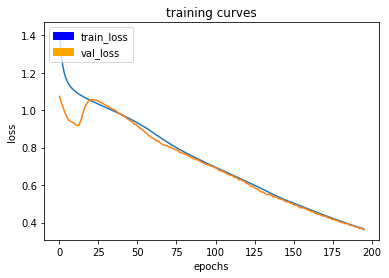

42/42 [==============================] - 62s - loss: 0.3659 - val_loss: 0.3604
Epoch 197/300
41/42 [============================>.] - ETA: 1s - loss: 0.3626

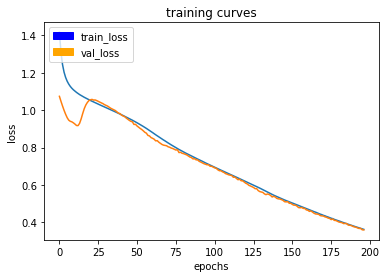

42/42 [==============================] - 61s - loss: 0.3631 - val_loss: 0.3599
Epoch 198/300
41/42 [============================>.] - ETA: 1s - loss: 0.3602

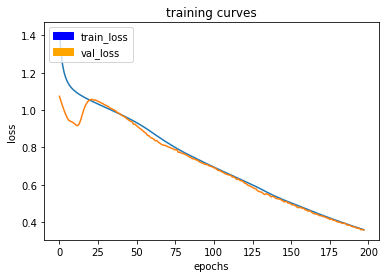

42/42 [==============================] - 61s - loss: 0.3600 - val_loss: 0.3589
Epoch 199/300
41/42 [============================>.] - ETA: 1s - loss: 0.3573

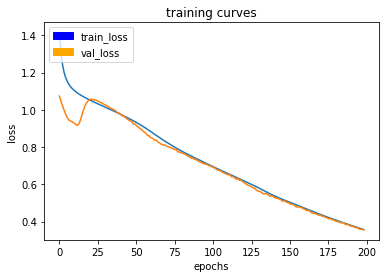

42/42 [==============================] - 62s - loss: 0.3575 - val_loss: 0.3556
Epoch 200/300
41/42 [============================>.] - ETA: 1s - loss: 0.3548

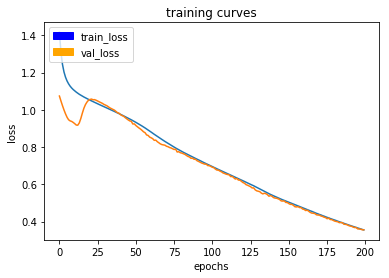

42/42 [==============================] - 62s - loss: 0.3551 - val_loss: 0.3554
Epoch 201/300
41/42 [============================>.] - ETA: 1s - loss: 0.3527

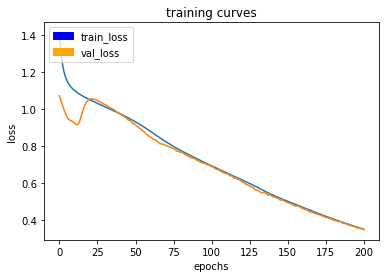

42/42 [==============================] - 61s - loss: 0.3527 - val_loss: 0.3488
Epoch 202/300
41/42 [============================>.] - ETA: 1s - loss: 0.3496

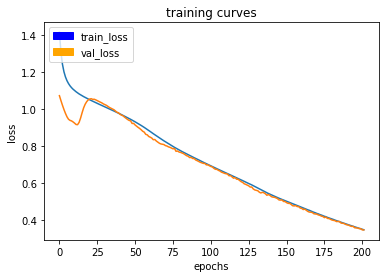

42/42 [==============================] - 61s - loss: 0.3498 - val_loss: 0.3487
Epoch 203/300
41/42 [============================>.] - ETA: 1s - loss: 0.3475

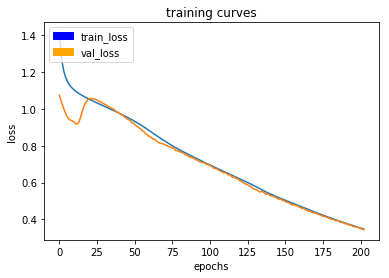

42/42 [==============================] - 61s - loss: 0.3470 - val_loss: 0.3426
Epoch 204/300
41/42 [============================>.] - ETA: 1s - loss: 0.3453

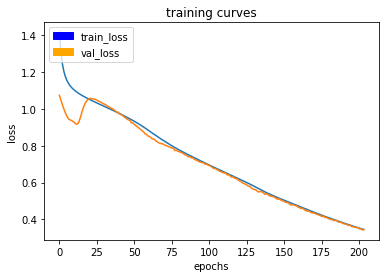

42/42 [==============================] - 62s - loss: 0.3455 - val_loss: 0.3436
Epoch 205/300
41/42 [============================>.] - ETA: 1s - loss: 0.3427

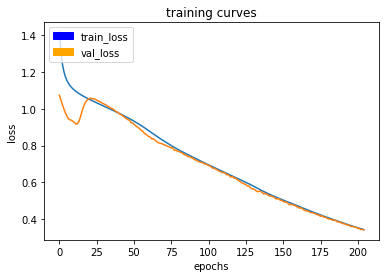

42/42 [==============================] - 61s - loss: 0.3422 - val_loss: 0.3409
Epoch 206/300
41/42 [============================>.] - ETA: 1s - loss: 0.3395

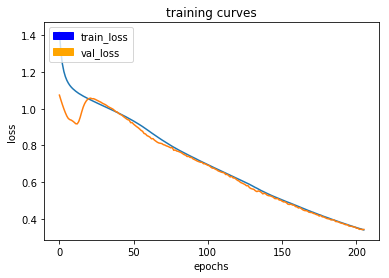

42/42 [==============================] - 61s - loss: 0.3396 - val_loss: 0.3423
Epoch 207/300
41/42 [============================>.] - ETA: 1s - loss: 0.3376

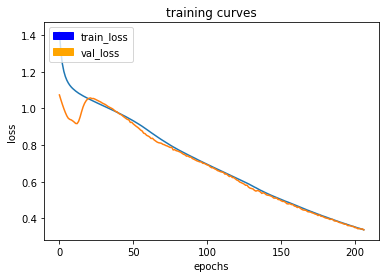

42/42 [==============================] - 62s - loss: 0.3375 - val_loss: 0.3364
Epoch 208/300
41/42 [============================>.] - ETA: 1s - loss: 0.3346

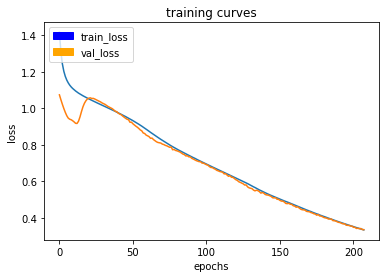

42/42 [==============================] - 61s - loss: 0.3345 - val_loss: 0.3359
Epoch 209/300
41/42 [============================>.] - ETA: 1s - loss: 0.3326

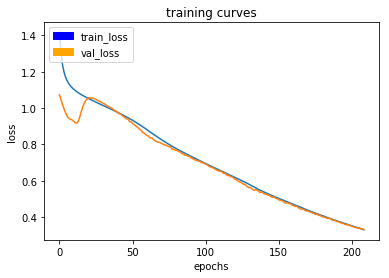

42/42 [==============================] - 61s - loss: 0.3329 - val_loss: 0.3304
Epoch 210/300
41/42 [============================>.] - ETA: 1s - loss: 0.3301

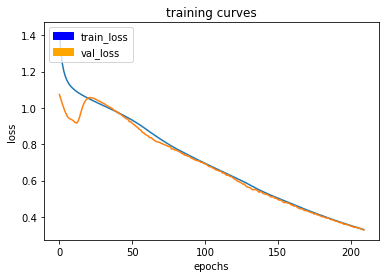

42/42 [==============================] - 62s - loss: 0.3302 - val_loss: 0.3282
Epoch 211/300
41/42 [============================>.] - ETA: 1s - loss: 0.3276

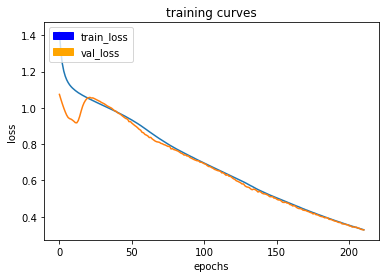

42/42 [==============================] - 62s - loss: 0.3281 - val_loss: 0.3270
Epoch 212/300
41/42 [============================>.] - ETA: 1s - loss: 0.3252

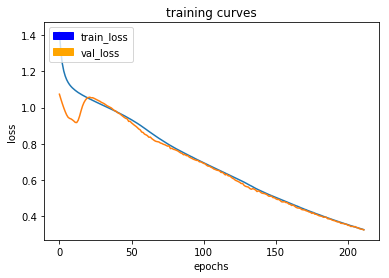

42/42 [==============================] - 61s - loss: 0.3254 - val_loss: 0.3237
Epoch 213/300
41/42 [============================>.] - ETA: 1s - loss: 0.3228

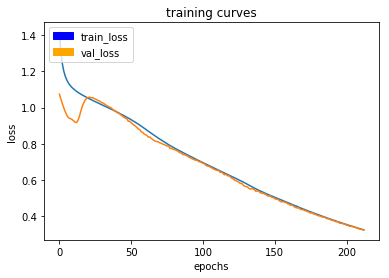

42/42 [==============================] - 62s - loss: 0.3229 - val_loss: 0.3228
Epoch 214/300
41/42 [============================>.] - ETA: 1s - loss: 0.3205

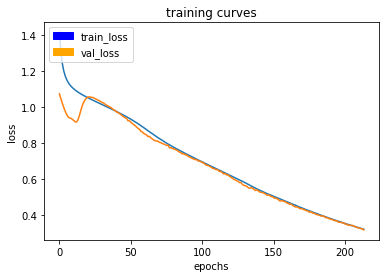

42/42 [==============================] - 62s - loss: 0.3204 - val_loss: 0.3167
Epoch 215/300
41/42 [============================>.] - ETA: 1s - loss: 0.3182

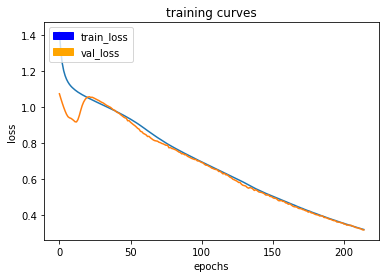

42/42 [==============================] - 61s - loss: 0.3188 - val_loss: 0.3161
Epoch 216/300
41/42 [============================>.] - ETA: 1s - loss: 0.3158

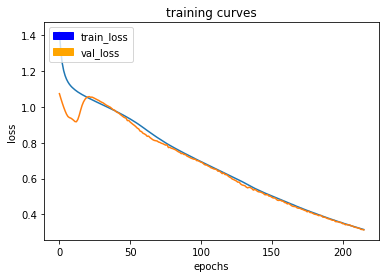

42/42 [==============================] - 62s - loss: 0.3162 - val_loss: 0.3138
Epoch 217/300
41/42 [============================>.] - ETA: 1s - loss: 0.3135

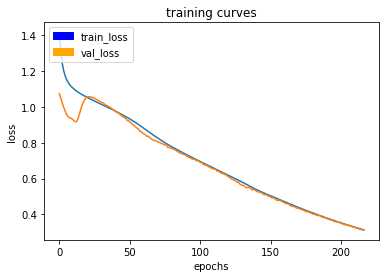

42/42 [==============================] - 62s - loss: 0.3140 - val_loss: 0.3137
Epoch 218/300
41/42 [============================>.] - ETA: 1s - loss: 0.3113

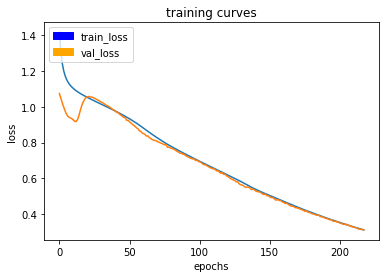

42/42 [==============================] - 62s - loss: 0.3110 - val_loss: 0.3122
Epoch 219/300
41/42 [============================>.] - ETA: 1s - loss: 0.3090

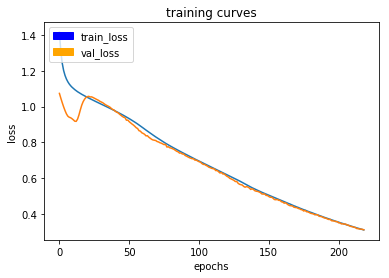

42/42 [==============================] - 61s - loss: 0.3094 - val_loss: 0.3099
Epoch 220/300
41/42 [============================>.] - ETA: 1s - loss: 0.3068

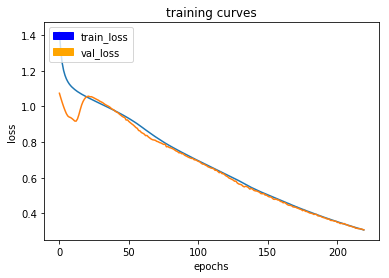

42/42 [==============================] - 62s - loss: 0.3066 - val_loss: 0.3071
Epoch 221/300
41/42 [============================>.] - ETA: 1s - loss: 0.3046

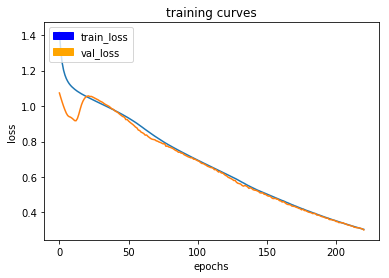

42/42 [==============================] - 62s - loss: 0.3045 - val_loss: 0.3016
Epoch 222/300
41/42 [============================>.] - ETA: 1s - loss: 0.3021

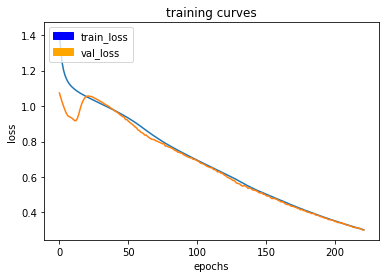

42/42 [==============================] - 61s - loss: 0.3025 - val_loss: 0.3015
Epoch 223/300
41/42 [============================>.] - ETA: 1s - loss: 0.3002

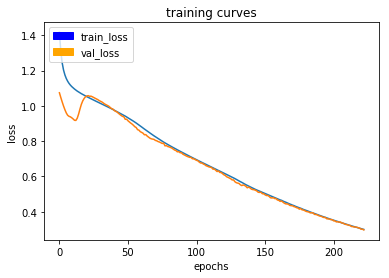

42/42 [==============================] - 62s - loss: 0.3001 - val_loss: 0.2974
Epoch 224/300
41/42 [============================>.] - ETA: 1s - loss: 0.2978

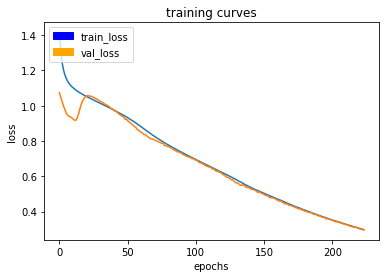

42/42 [==============================] - 61s - loss: 0.2982 - val_loss: 0.2963
Epoch 225/300
41/42 [============================>.] - ETA: 1s - loss: 0.2960

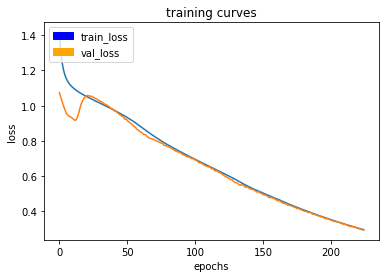

42/42 [==============================] - 62s - loss: 0.2961 - val_loss: 0.2948
Epoch 226/300
41/42 [============================>.] - ETA: 1s - loss: 0.2940

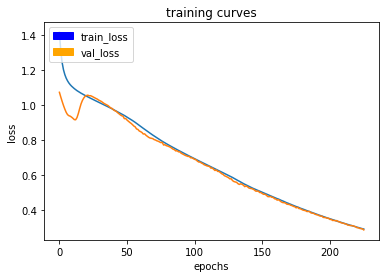

42/42 [==============================] - 62s - loss: 0.2937 - val_loss: 0.2890
Epoch 227/300
41/42 [============================>.] - ETA: 1s - loss: 0.2914

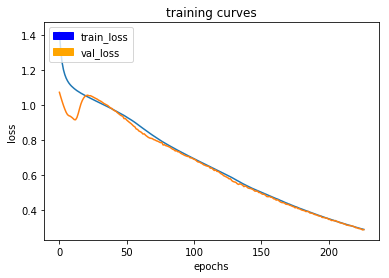

42/42 [==============================] - 62s - loss: 0.2918 - val_loss: 0.2907
Epoch 228/300
41/42 [============================>.] - ETA: 1s - loss: 0.2899

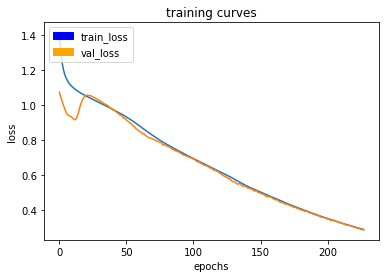

42/42 [==============================] - 61s - loss: 0.2899 - val_loss: 0.2874
Epoch 229/300
41/42 [============================>.] - ETA: 1s - loss: 0.2873

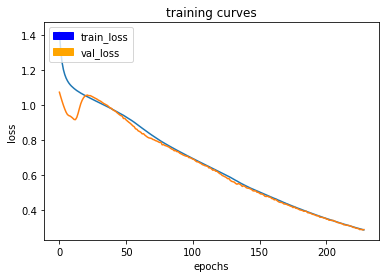

42/42 [==============================] - 61s - loss: 0.2872 - val_loss: 0.2892
Epoch 230/300
41/42 [============================>.] - ETA: 1s - loss: 0.2854

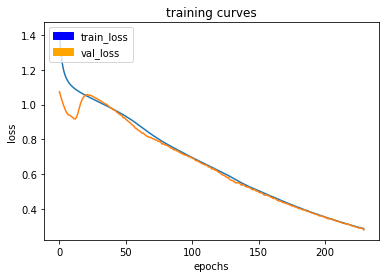

42/42 [==============================] - 62s - loss: 0.2847 - val_loss: 0.2785
Epoch 231/300
41/42 [============================>.] - ETA: 1s - loss: 0.2830

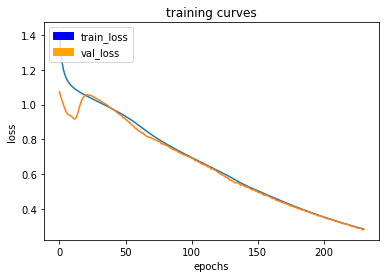

42/42 [==============================] - 62s - loss: 0.2829 - val_loss: 0.2814
Epoch 232/300
41/42 [============================>.] - ETA: 1s - loss: 0.2810

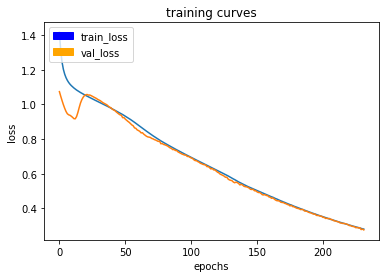

42/42 [==============================] - 61s - loss: 0.2812 - val_loss: 0.2764
Epoch 233/300
41/42 [============================>.] - ETA: 1s - loss: 0.2790

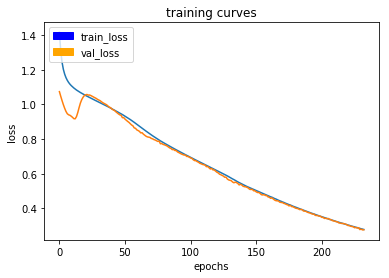

42/42 [==============================] - 62s - loss: 0.2789 - val_loss: 0.2772
Epoch 234/300
41/42 [============================>.] - ETA: 1s - loss: 0.2767

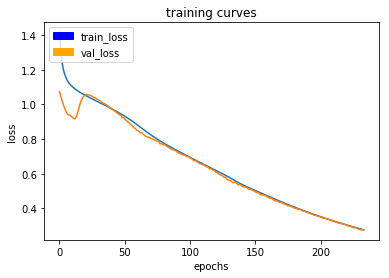

42/42 [==============================] - 62s - loss: 0.2772 - val_loss: 0.2770
Epoch 235/300
41/42 [============================>.] - ETA: 1s - loss: 0.2751

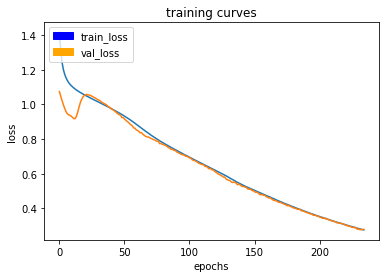

42/42 [==============================] - 62s - loss: 0.2754 - val_loss: 0.2785
Epoch 236/300
41/42 [============================>.] - ETA: 1s - loss: 0.2729

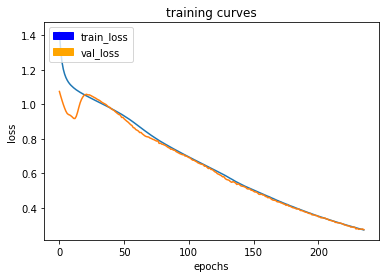

42/42 [==============================] - 61s - loss: 0.2731 - val_loss: 0.2748
Epoch 237/300
41/42 [============================>.] - ETA: 1s - loss: 0.2711

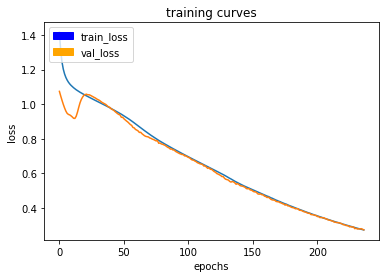

42/42 [==============================] - 62s - loss: 0.2717 - val_loss: 0.2716
Epoch 238/300
41/42 [============================>.] - ETA: 1s - loss: 0.2689

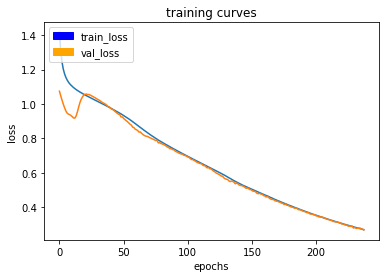

42/42 [==============================] - 62s - loss: 0.2684 - val_loss: 0.2675
Epoch 239/300
41/42 [============================>.] - ETA: 1s - loss: 0.2671

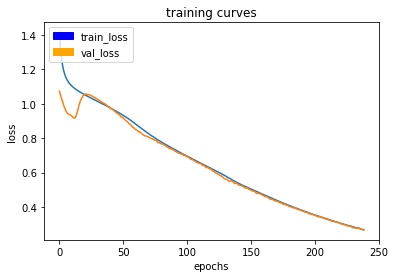

42/42 [==============================] - 61s - loss: 0.2672 - val_loss: 0.2662
Epoch 240/300
41/42 [============================>.] - ETA: 1s - loss: 0.2656

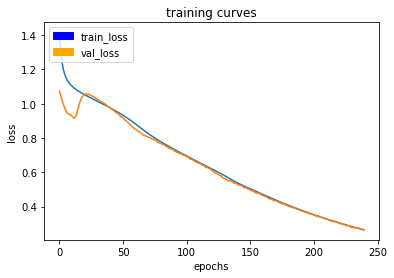

42/42 [==============================] - 61s - loss: 0.2656 - val_loss: 0.2644
Epoch 241/300
41/42 [============================>.] - ETA: 1s - loss: 0.2629

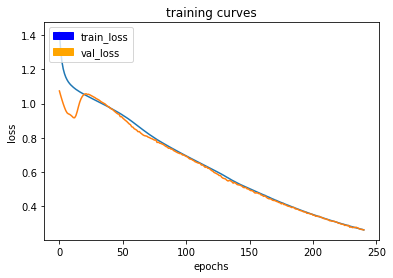

42/42 [==============================] - 61s - loss: 0.2631 - val_loss: 0.2631
Epoch 242/300
41/42 [============================>.] - ETA: 1s - loss: 0.2613

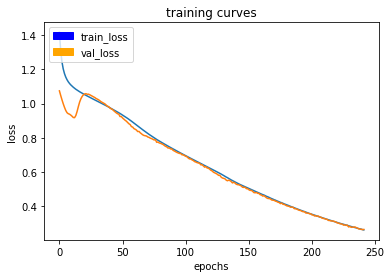

42/42 [==============================] - 62s - loss: 0.2609 - val_loss: 0.2640
Epoch 243/300
41/42 [============================>.] - ETA: 1s - loss: 0.2594

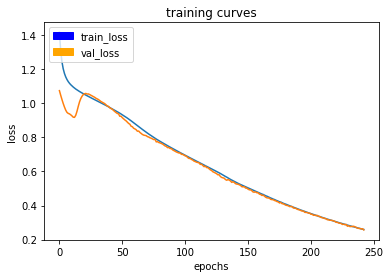

42/42 [==============================] - 62s - loss: 0.2598 - val_loss: 0.2570
Epoch 244/300
41/42 [============================>.] - ETA: 1s - loss: 0.2574

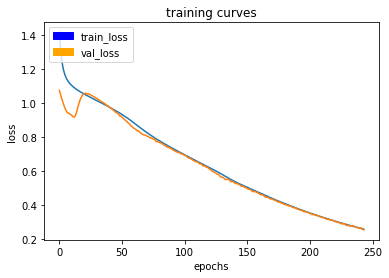

42/42 [==============================] - 61s - loss: 0.2573 - val_loss: 0.2529
Epoch 245/300
41/42 [============================>.] - ETA: 1s - loss: 0.2560

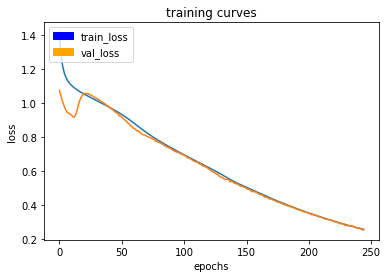

42/42 [==============================] - 61s - loss: 0.2555 - val_loss: 0.2542
Epoch 246/300
41/42 [============================>.] - ETA: 1s - loss: 0.2538

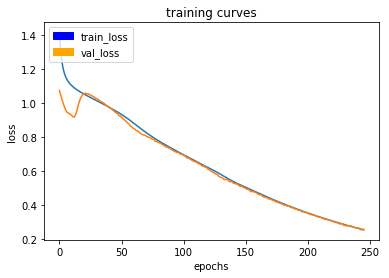

42/42 [==============================] - 61s - loss: 0.2539 - val_loss: 0.2562
Epoch 247/300
41/42 [============================>.] - ETA: 1s - loss: 0.2515

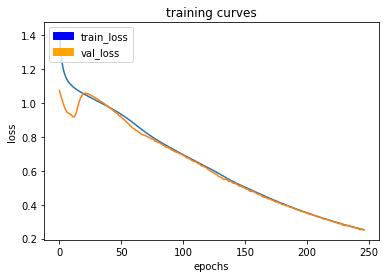

42/42 [==============================] - 61s - loss: 0.2515 - val_loss: 0.2525
Epoch 248/300
41/42 [============================>.] - ETA: 1s - loss: 0.2496

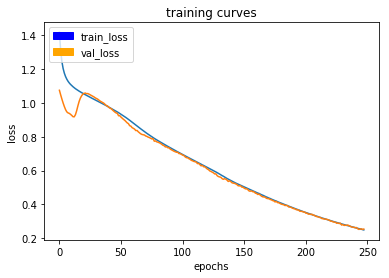

42/42 [==============================] - 62s - loss: 0.2502 - val_loss: 0.2549
Epoch 249/300
41/42 [============================>.] - ETA: 1s - loss: 0.2484

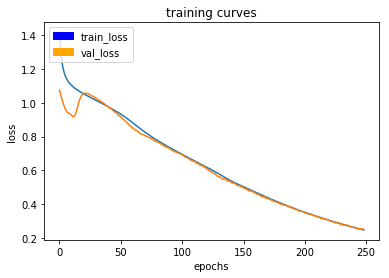

42/42 [==============================] - 61s - loss: 0.2485 - val_loss: 0.2515
Epoch 250/300
41/42 [============================>.] - ETA: 1s - loss: 0.2465

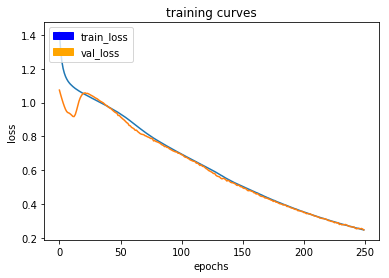

42/42 [==============================] - 61s - loss: 0.2463 - val_loss: 0.2463
Epoch 251/300
41/42 [============================>.] - ETA: 1s - loss: 0.2446

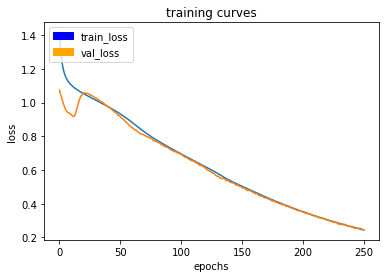

42/42 [==============================] - 62s - loss: 0.2447 - val_loss: 0.2447
Epoch 252/300
41/42 [============================>.] - ETA: 1s - loss: 0.2425

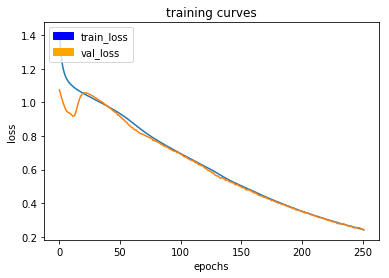

42/42 [==============================] - 61s - loss: 0.2424 - val_loss: 0.2411
Epoch 253/300
41/42 [============================>.] - ETA: 1s - loss: 0.2410

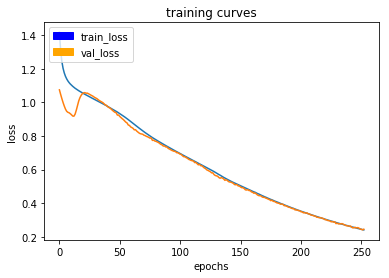

42/42 [==============================] - 61s - loss: 0.2410 - val_loss: 0.2452
Epoch 254/300
41/42 [============================>.] - ETA: 1s - loss: 0.2391

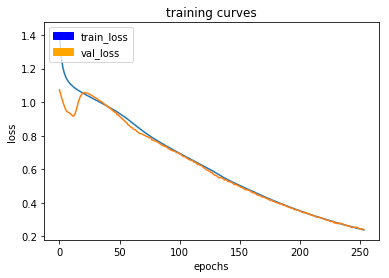

42/42 [==============================] - 62s - loss: 0.2386 - val_loss: 0.2409
Epoch 255/300
41/42 [============================>.] - ETA: 1s - loss: 0.2370

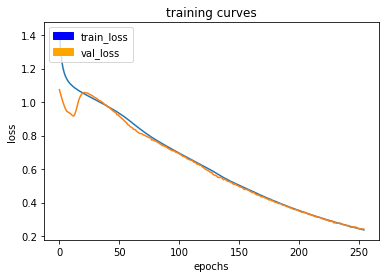

42/42 [==============================] - 61s - loss: 0.2369 - val_loss: 0.2428
Epoch 256/300
41/42 [============================>.] - ETA: 1s - loss: 0.2356

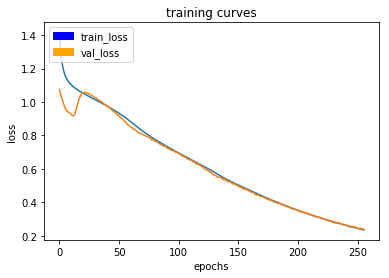

42/42 [==============================] - 62s - loss: 0.2353 - val_loss: 0.2362
Epoch 257/300
41/42 [============================>.] - ETA: 1s - loss: 0.2338

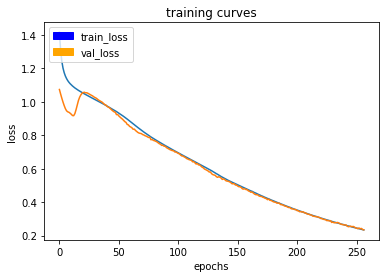

42/42 [==============================] - 61s - loss: 0.2339 - val_loss: 0.2341
Epoch 258/300
41/42 [============================>.] - ETA: 1s - loss: 0.2321

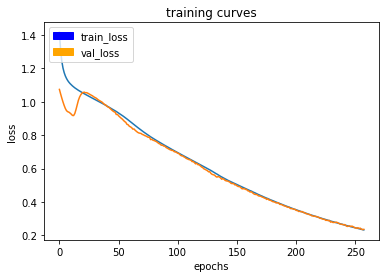

42/42 [==============================] - 61s - loss: 0.2320 - val_loss: 0.2355
Epoch 259/300
41/42 [============================>.] - ETA: 1s - loss: 0.2302

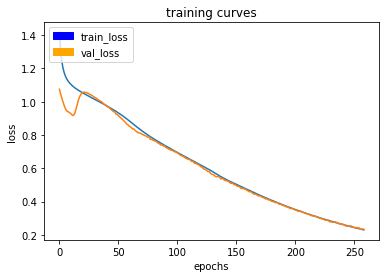

42/42 [==============================] - 62s - loss: 0.2304 - val_loss: 0.2347
Epoch 260/300
41/42 [============================>.] - ETA: 1s - loss: 0.2286

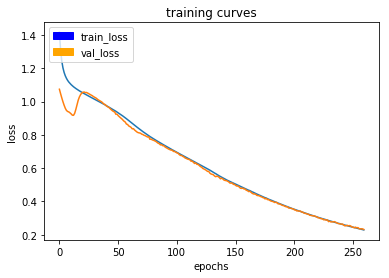

42/42 [==============================] - 62s - loss: 0.2287 - val_loss: 0.2313
Epoch 261/300
41/42 [============================>.] - ETA: 1s - loss: 0.2269

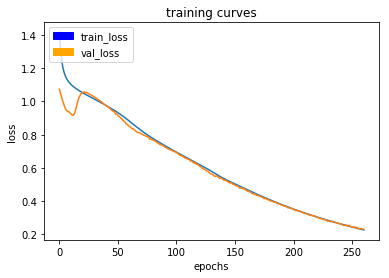

42/42 [==============================] - 61s - loss: 0.2271 - val_loss: 0.2310
Epoch 262/300
41/42 [============================>.] - ETA: 1s - loss: 0.2256

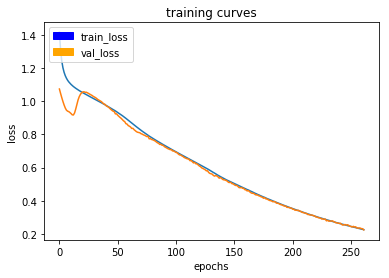

42/42 [==============================] - 62s - loss: 0.2248 - val_loss: 0.2237
Epoch 263/300
41/42 [============================>.] - ETA: 1s - loss: 0.2238

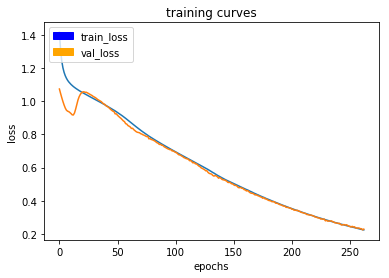

42/42 [==============================] - 61s - loss: 0.2239 - val_loss: 0.2286
Epoch 264/300
41/42 [============================>.] - ETA: 1s - loss: 0.2222

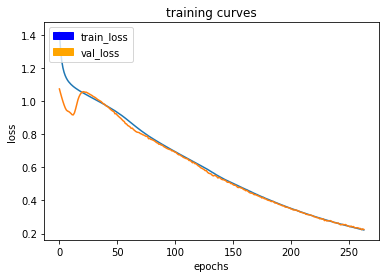

42/42 [==============================] - 62s - loss: 0.2223 - val_loss: 0.2251
Epoch 265/300
41/42 [============================>.] - ETA: 1s - loss: 0.2202

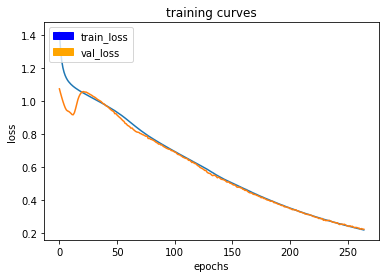

42/42 [==============================] - 62s - loss: 0.2205 - val_loss: 0.2243
Epoch 266/300
41/42 [============================>.] - ETA: 1s - loss: 0.2189

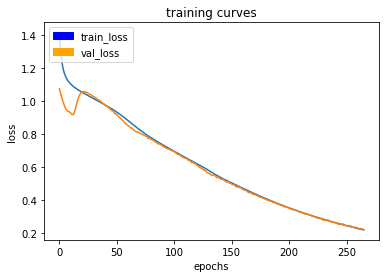

42/42 [==============================] - 62s - loss: 0.2188 - val_loss: 0.2205
Epoch 267/300
41/42 [============================>.] - ETA: 1s - loss: 0.2174

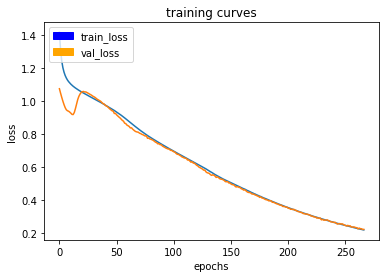

42/42 [==============================] - 61s - loss: 0.2178 - val_loss: 0.2208
Epoch 268/300
41/42 [============================>.] - ETA: 1s - loss: 0.2155

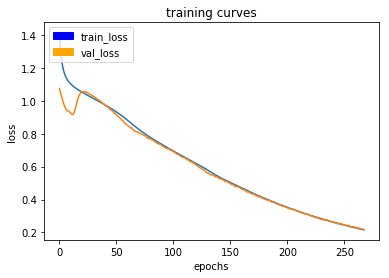

42/42 [==============================] - 62s - loss: 0.2153 - val_loss: 0.2189
Epoch 269/300
41/42 [============================>.] - ETA: 1s - loss: 0.2140

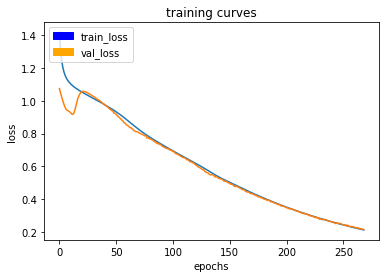

42/42 [==============================] - 61s - loss: 0.2143 - val_loss: 0.2164
Epoch 270/300
41/42 [============================>.] - ETA: 1s - loss: 0.2124

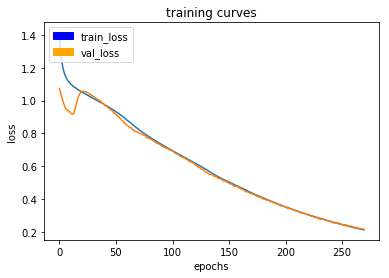

42/42 [==============================] - 62s - loss: 0.2126 - val_loss: 0.2180
Epoch 271/300
41/42 [============================>.] - ETA: 1s - loss: 0.2107

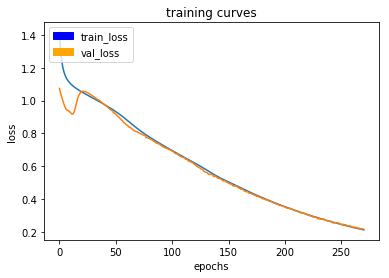

42/42 [==============================] - 62s - loss: 0.2109 - val_loss: 0.2137
Epoch 272/300
41/42 [============================>.] - ETA: 1s - loss: 0.2093

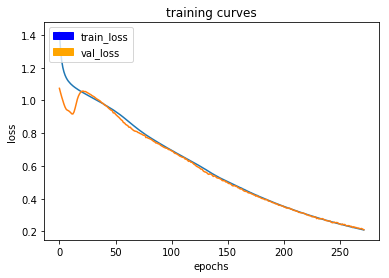

42/42 [==============================] - 62s - loss: 0.2092 - val_loss: 0.2106
Epoch 273/300
41/42 [============================>.] - ETA: 1s - loss: 0.2076

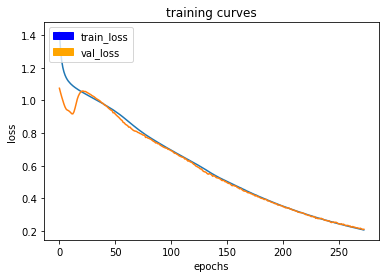

42/42 [==============================] - 61s - loss: 0.2079 - val_loss: 0.2118
Epoch 274/300
41/42 [============================>.] - ETA: 1s - loss: 0.2060

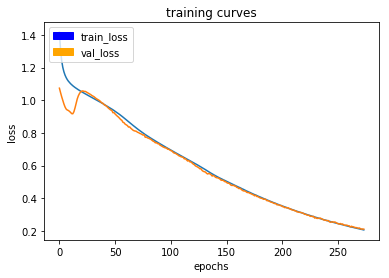

42/42 [==============================] - 62s - loss: 0.2062 - val_loss: 0.2108
Epoch 275/300
41/42 [============================>.] - ETA: 1s - loss: 0.2048

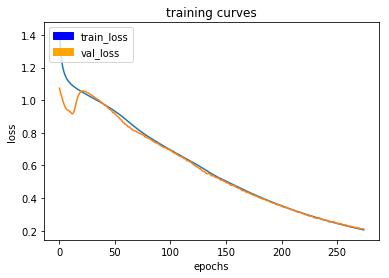

42/42 [==============================] - 62s - loss: 0.2046 - val_loss: 0.2102
Epoch 276/300
41/42 [============================>.] - ETA: 1s - loss: 0.2026

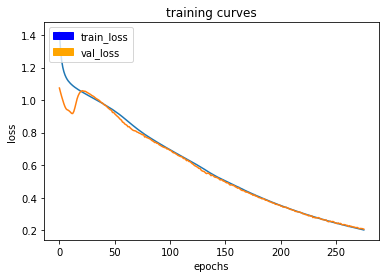

42/42 [==============================] - 62s - loss: 0.2029 - val_loss: 0.2072
Epoch 277/300
41/42 [============================>.] - ETA: 1s - loss: 0.2014

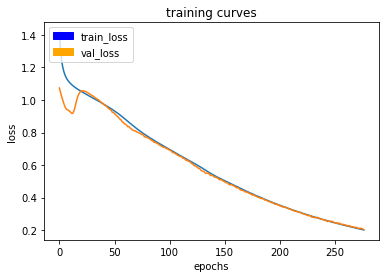

42/42 [==============================] - 61s - loss: 0.2011 - val_loss: 0.2031
Epoch 278/300
41/42 [============================>.] - ETA: 1s - loss: 0.2001

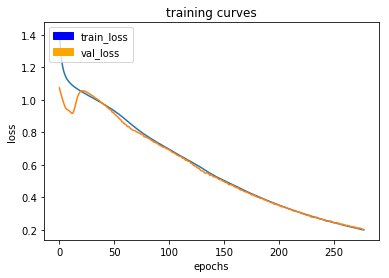

42/42 [==============================] - 62s - loss: 0.1998 - val_loss: 0.2033
Epoch 279/300
41/42 [============================>.] - ETA: 1s - loss: 0.1983

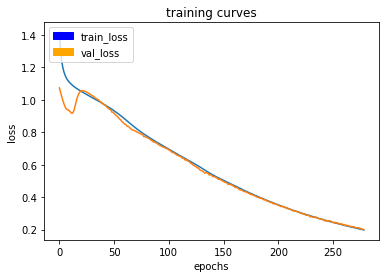

42/42 [==============================] - 62s - loss: 0.1984 - val_loss: 0.1999
Epoch 280/300
41/42 [============================>.] - ETA: 1s - loss: 0.1972

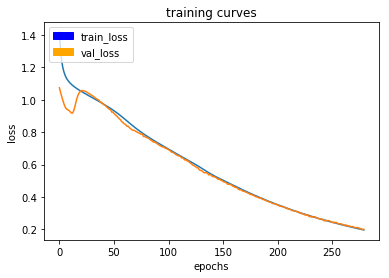

42/42 [==============================] - 62s - loss: 0.1968 - val_loss: 0.2009
Epoch 281/300
41/42 [============================>.] - ETA: 1s - loss: 0.1957

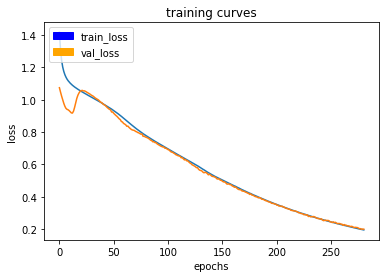

42/42 [==============================] - 61s - loss: 0.1954 - val_loss: 0.2002
Epoch 282/300
41/42 [============================>.] - ETA: 1s - loss: 0.1944

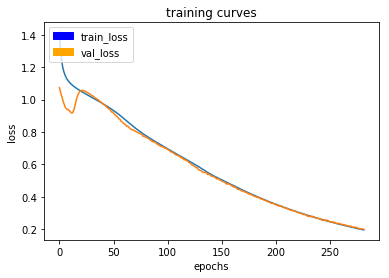

42/42 [==============================] - 62s - loss: 0.1946 - val_loss: 0.1983
Epoch 283/300
41/42 [============================>.] - ETA: 1s - loss: 0.1930

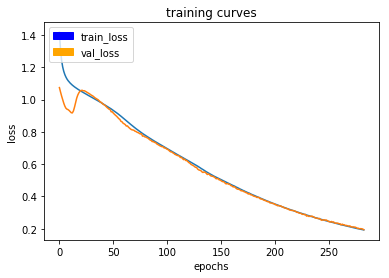

42/42 [==============================] - 61s - loss: 0.1929 - val_loss: 0.1945
Epoch 284/300
41/42 [============================>.] - ETA: 1s - loss: 0.1911

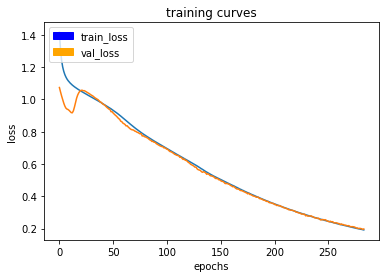

42/42 [==============================] - 61s - loss: 0.1917 - val_loss: 0.1972
Epoch 285/300
41/42 [============================>.] - ETA: 1s - loss: 0.1898

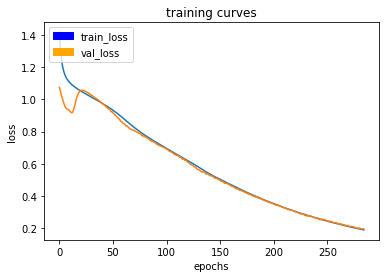

42/42 [==============================] - 61s - loss: 0.1898 - val_loss: 0.1966
Epoch 286/300
41/42 [============================>.] - ETA: 1s - loss: 0.1886

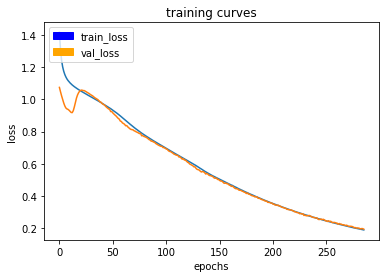

42/42 [==============================] - 62s - loss: 0.1890 - val_loss: 0.1931
Epoch 287/300
41/42 [============================>.] - ETA: 1s - loss: 0.1869

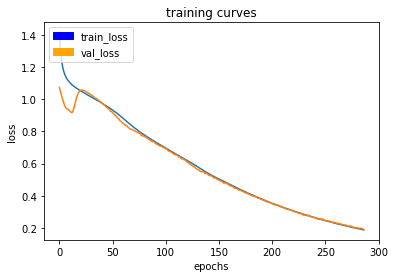

42/42 [==============================] - 61s - loss: 0.1870 - val_loss: 0.1879
Epoch 288/300
41/42 [============================>.] - ETA: 1s - loss: 0.1861

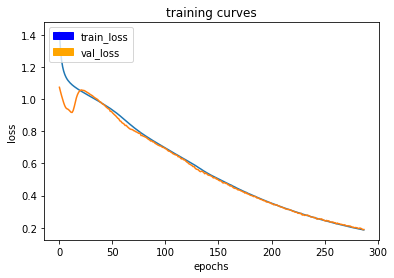

42/42 [==============================] - 61s - loss: 0.1861 - val_loss: 0.1887
Epoch 289/300
41/42 [============================>.] - ETA: 1s - loss: 0.1843

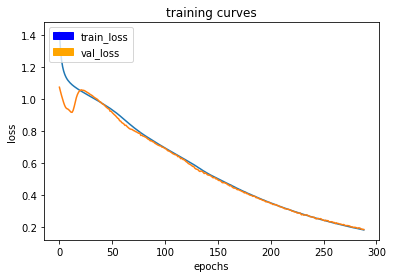

42/42 [==============================] - 62s - loss: 0.1843 - val_loss: 0.1870
Epoch 290/300
41/42 [============================>.] - ETA: 1s - loss: 0.1832

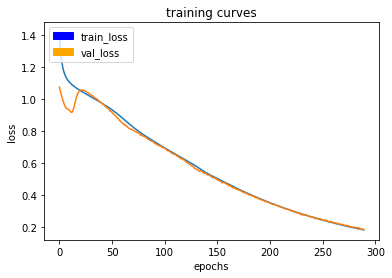

42/42 [==============================] - 62s - loss: 0.1832 - val_loss: 0.1865
Epoch 291/300
41/42 [============================>.] - ETA: 1s - loss: 0.1816

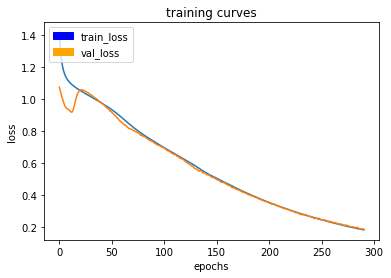

42/42 [==============================] - 62s - loss: 0.1817 - val_loss: 0.1877
Epoch 292/300
41/42 [============================>.] - ETA: 1s - loss: 0.1802

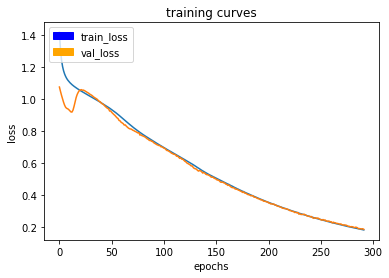

42/42 [==============================] - 61s - loss: 0.1805 - val_loss: 0.1838
Epoch 293/300
41/42 [============================>.] - ETA: 1s - loss: 0.1790

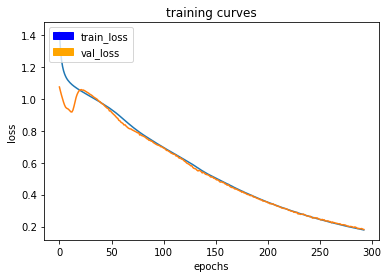

42/42 [==============================] - 61s - loss: 0.1794 - val_loss: 0.1819
Epoch 294/300
41/42 [============================>.] - ETA: 1s - loss: 0.1775

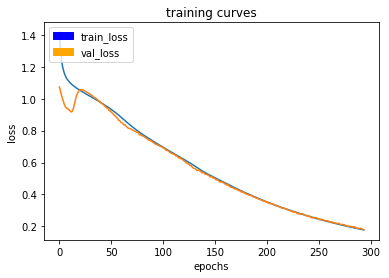

42/42 [==============================] - 61s - loss: 0.1773 - val_loss: 0.1785
Epoch 295/300
41/42 [============================>.] - ETA: 1s - loss: 0.1766

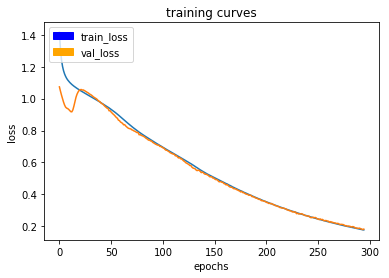

42/42 [==============================] - 62s - loss: 0.1764 - val_loss: 0.1817
Epoch 296/300
41/42 [============================>.] - ETA: 1s - loss: 0.1749

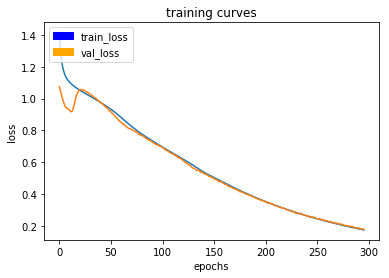

42/42 [==============================] - 62s - loss: 0.1747 - val_loss: 0.1796
Epoch 297/300
41/42 [============================>.] - ETA: 1s - loss: 0.1735

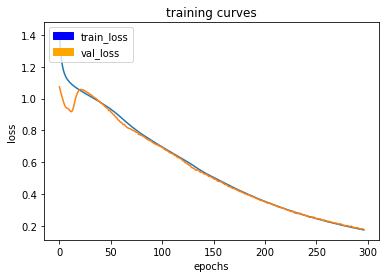

42/42 [==============================] - 62s - loss: 0.1740 - val_loss: 0.1771
Epoch 298/300
41/42 [============================>.] - ETA: 1s - loss: 0.1724

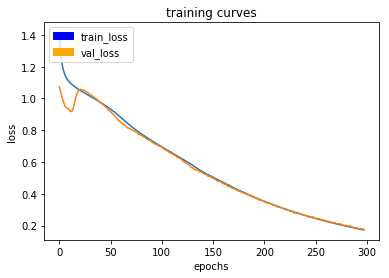

42/42 [==============================] - 62s - loss: 0.1722 - val_loss: 0.1770
Epoch 299/300
41/42 [============================>.] - ETA: 1s - loss: 0.1709

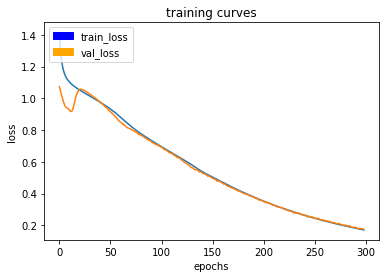

42/42 [==============================] - 62s - loss: 0.1711 - val_loss: 0.1753
Epoch 300/300
41/42 [============================>.] - ETA: 1s - loss: 0.1699

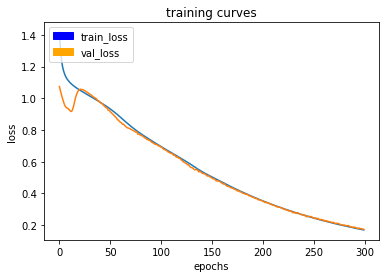

42/42 [==============================] - 62s - loss: 0.1698 - val_loss: 0.1735


In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [10]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)
model.summary()

#keras.plot_model(model, to_file='model.png')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
separable_conv2d_keras_1 (Se (None, 80, 80, 32)        155       
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 80, 32)        128       
_________________________________________________________________
separable_conv2d_keras_2 (Se (None, 40, 40, 64)        2400      
_________________________________________________________________
batch_normalization_2 (Batch (None, 40, 40, 64)        256       
_________________________________________________________________
separable_conv2d_keras_3 (Se (None, 20, 20, 128)       8896      
_________________________________________________________________
batch_normalization_3 (Batch (None, 20, 20, 128)       512       
__________

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [11]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

weight_file_name = 'model_weights'
restored_model = model_tools.load_network(weight_file_name)

The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [12]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

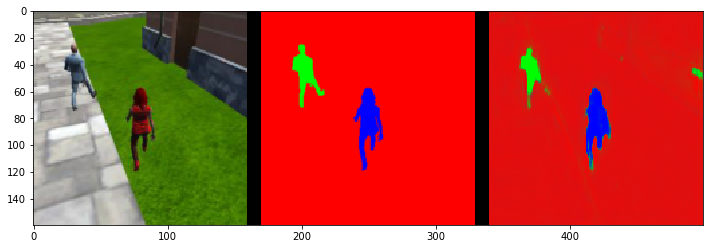

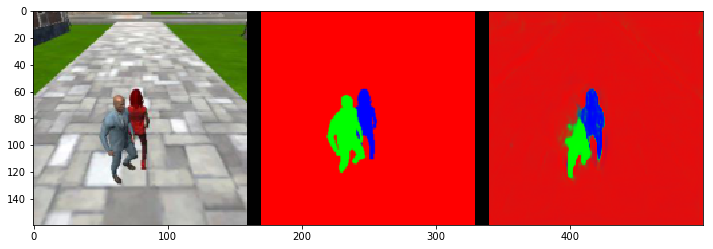

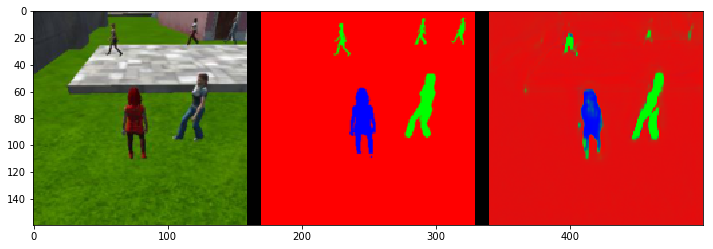

In [13]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

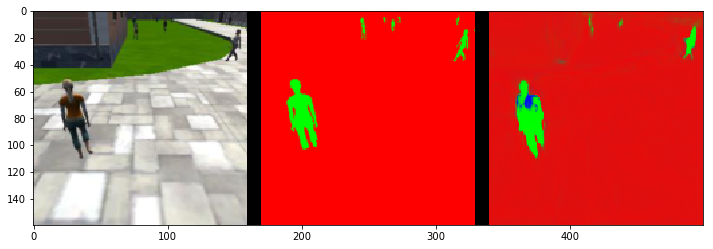

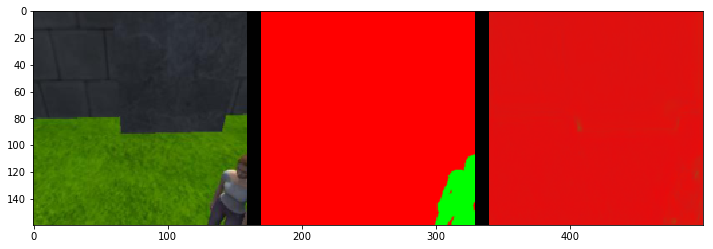

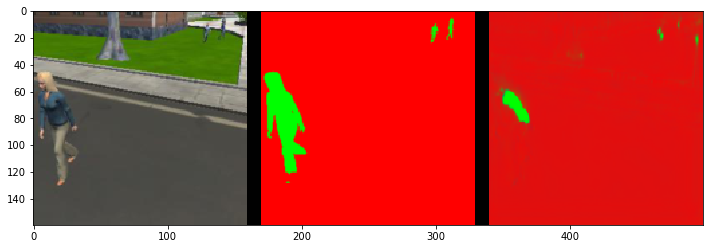

In [14]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

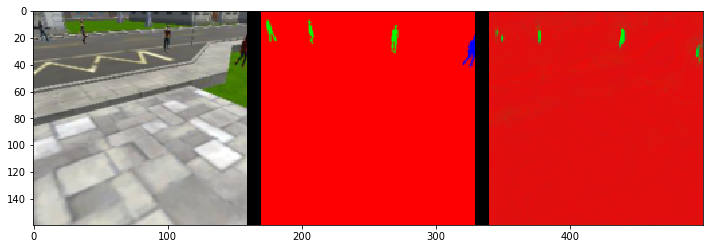

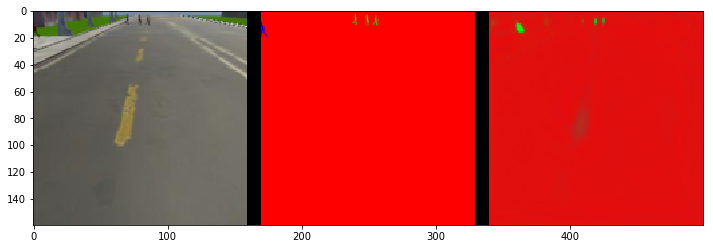

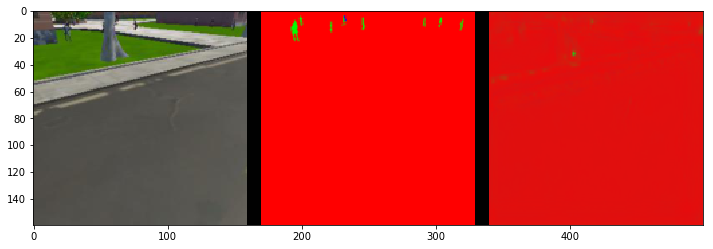

In [15]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [16]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9913543458539502
average intersection over union for other people is 0.17529582514520825
average intersection over union for the hero is 0.797724500270387
number true positives: 539, number false positives: 0, number false negatives: 0


In [17]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9765475775864236
average intersection over union for other people is 0.5123498250747847
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 126, number false negatives: 0


In [18]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9938482713714117
average intersection over union for other people is 0.2540446151314648
average intersection over union for the hero is 0.07116741989103666
number true positives: 81, number false positives: 3, number false negatives: 220


In [19]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.6398348813209495


In [20]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.434445960081


In [21]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.277973679309
